<h1> Spatial Clustering Insights from the 2023 City of Vancouver Property Tax Report </h1>

In [1]:
## Load Relevant Libraries 

# Tidyverse library used for wrangling and tidying data
library(tidyverse)

# Tidymodels library used for kmeans clustering
library(tidymodels)

# Broom used for tidy visualization of clustering
library(broom)

# ggpairs used to sort out which variables correlate strongly
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h1> 1. Data Specification </h1>
This project uses data from the City of Vancouver Open Data Portal 

In [2]:
#setting seed
set.seed(9876)
seed <- 9876

## 2023 CoV Property Tax Report Dataset imported by url (HTTP GET)
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   NEIGHBOURHOOD_CODE,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",") |>
# Convert (lat,long) into numeric data
            mutate(lat = as.double(lat)) |>
            mutate(long = as.double(long))

Rows: 220840 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100164 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
## Data Tidying
# Filter for housing properties only by zone
property_housing_only <- ptax_parcel_merged |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      # NOTE: Comprehensive Developments are mixed-use, and could look like an 
                                      # apartment building with shops below, or a shopping mall with a few apartments
                                      # above. This report acknowledges the limitations of this in further sections.
                                      "Single Detached House",
                                      "Multiple Dwelling"))

print(paste("Entry Count before NA and 0 removal: ", nrow(property_housing_only))) 
property_housing_only <- property_housing_only |>
                            drop_na()
print(paste("Entry Count after NA and 0 removal: ", nrow(property_housing_only)))

# Summary table counting each housing type
property_summ_table <- property_housing_only |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


[1] "Entry Count before NA and 0 removal:  60570"
[1] "Entry Count after NA and 0 removal:  58680"


ZONING_CLASSIFICATION     COUNT
1 Comprehensive Development 26316
2 Multiple Dwelling         10316
3 Single Detached House     22048

<h1> 2. Calculating Spatial Centroids </h1>

This project will use the spatial centroids of properties within each neighbourhood coded in the Property Tax Report  as an external validation. The first set of centroids consist of those that take into consideration all types of properties within a neighbourhood, and the second set of centroids consist of those that only take the locations of strata housing into consideration.  

<h2> Neighbourhood Centroids using All Properties </h2>

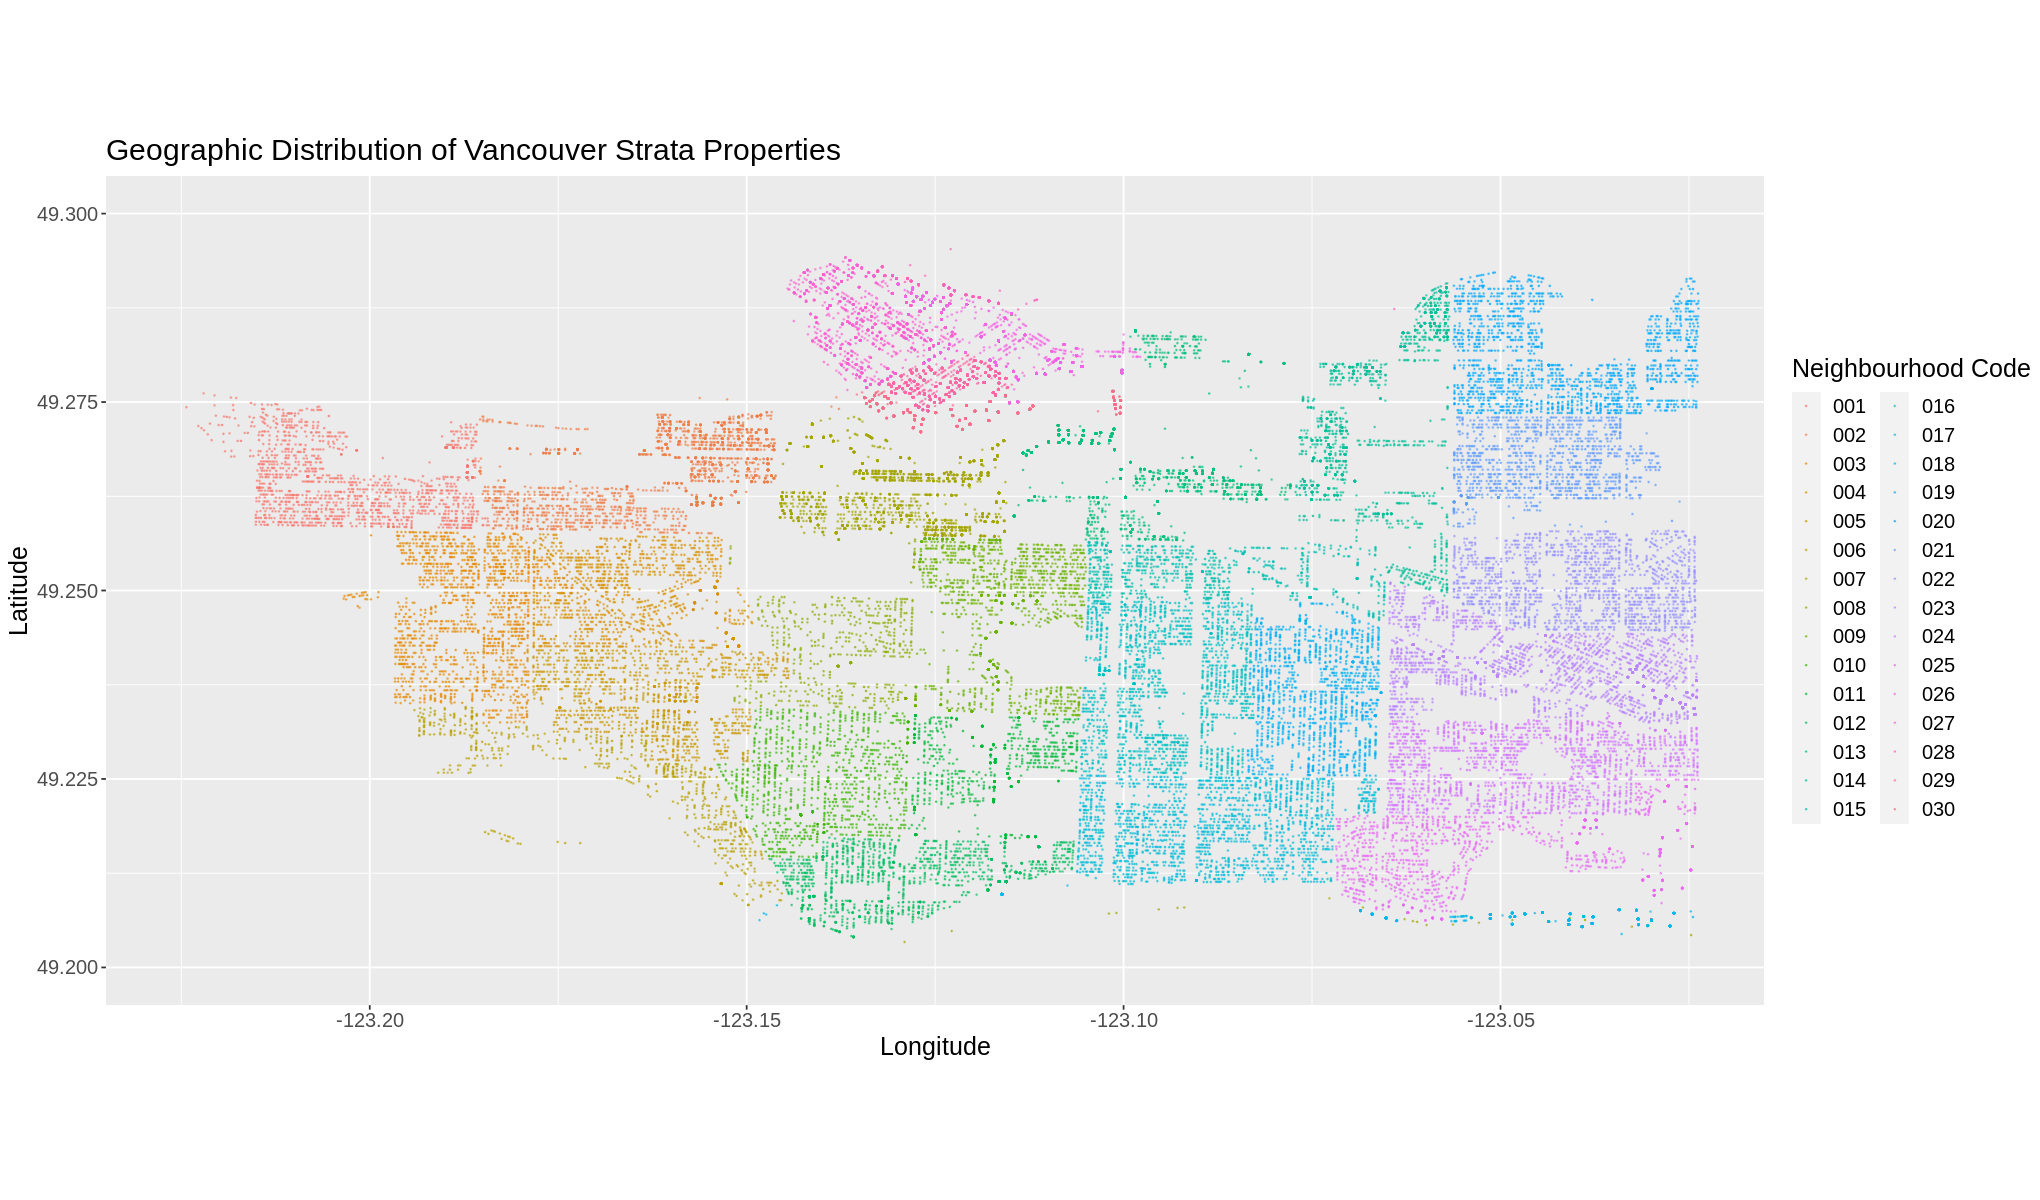

In [5]:
# This plot shows the spatial distribution of all properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
property_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
property_plot

<h2> Neighbourhood Centroids using Strata Properties Only </h2>

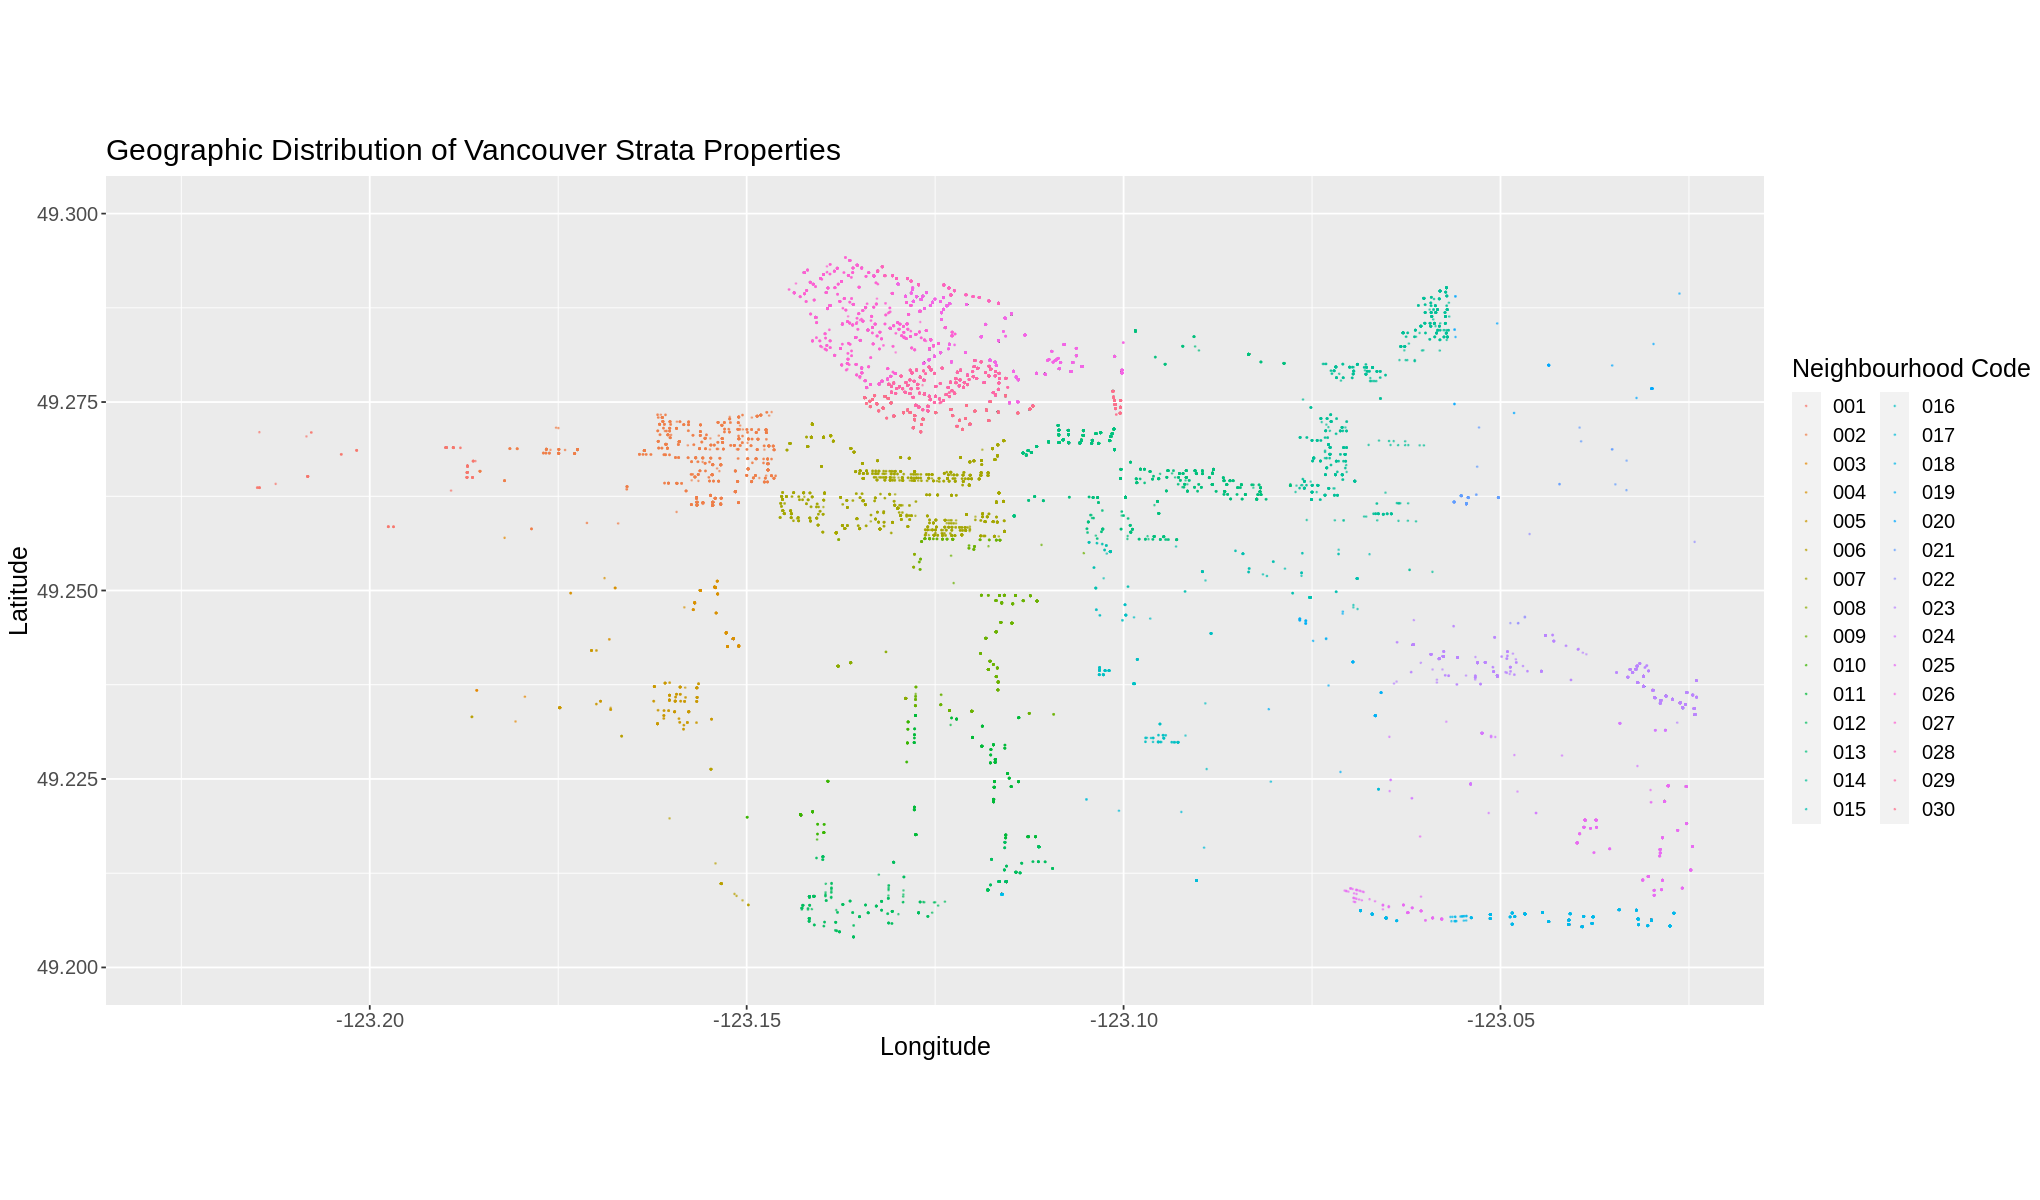

In [6]:
# This plot shows the spatial distribution of strata properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
strata_only_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
strata_only_plot

In [11]:
# Strata Housing Centroids
# Group by, summarize, and plot




<h1> 3. Model Parameter Tuning </h1> 
The model will be tuned a priori using the elbow plot method, and will qualitively compare the results using the calculated spatial centroids from Section 3 above.

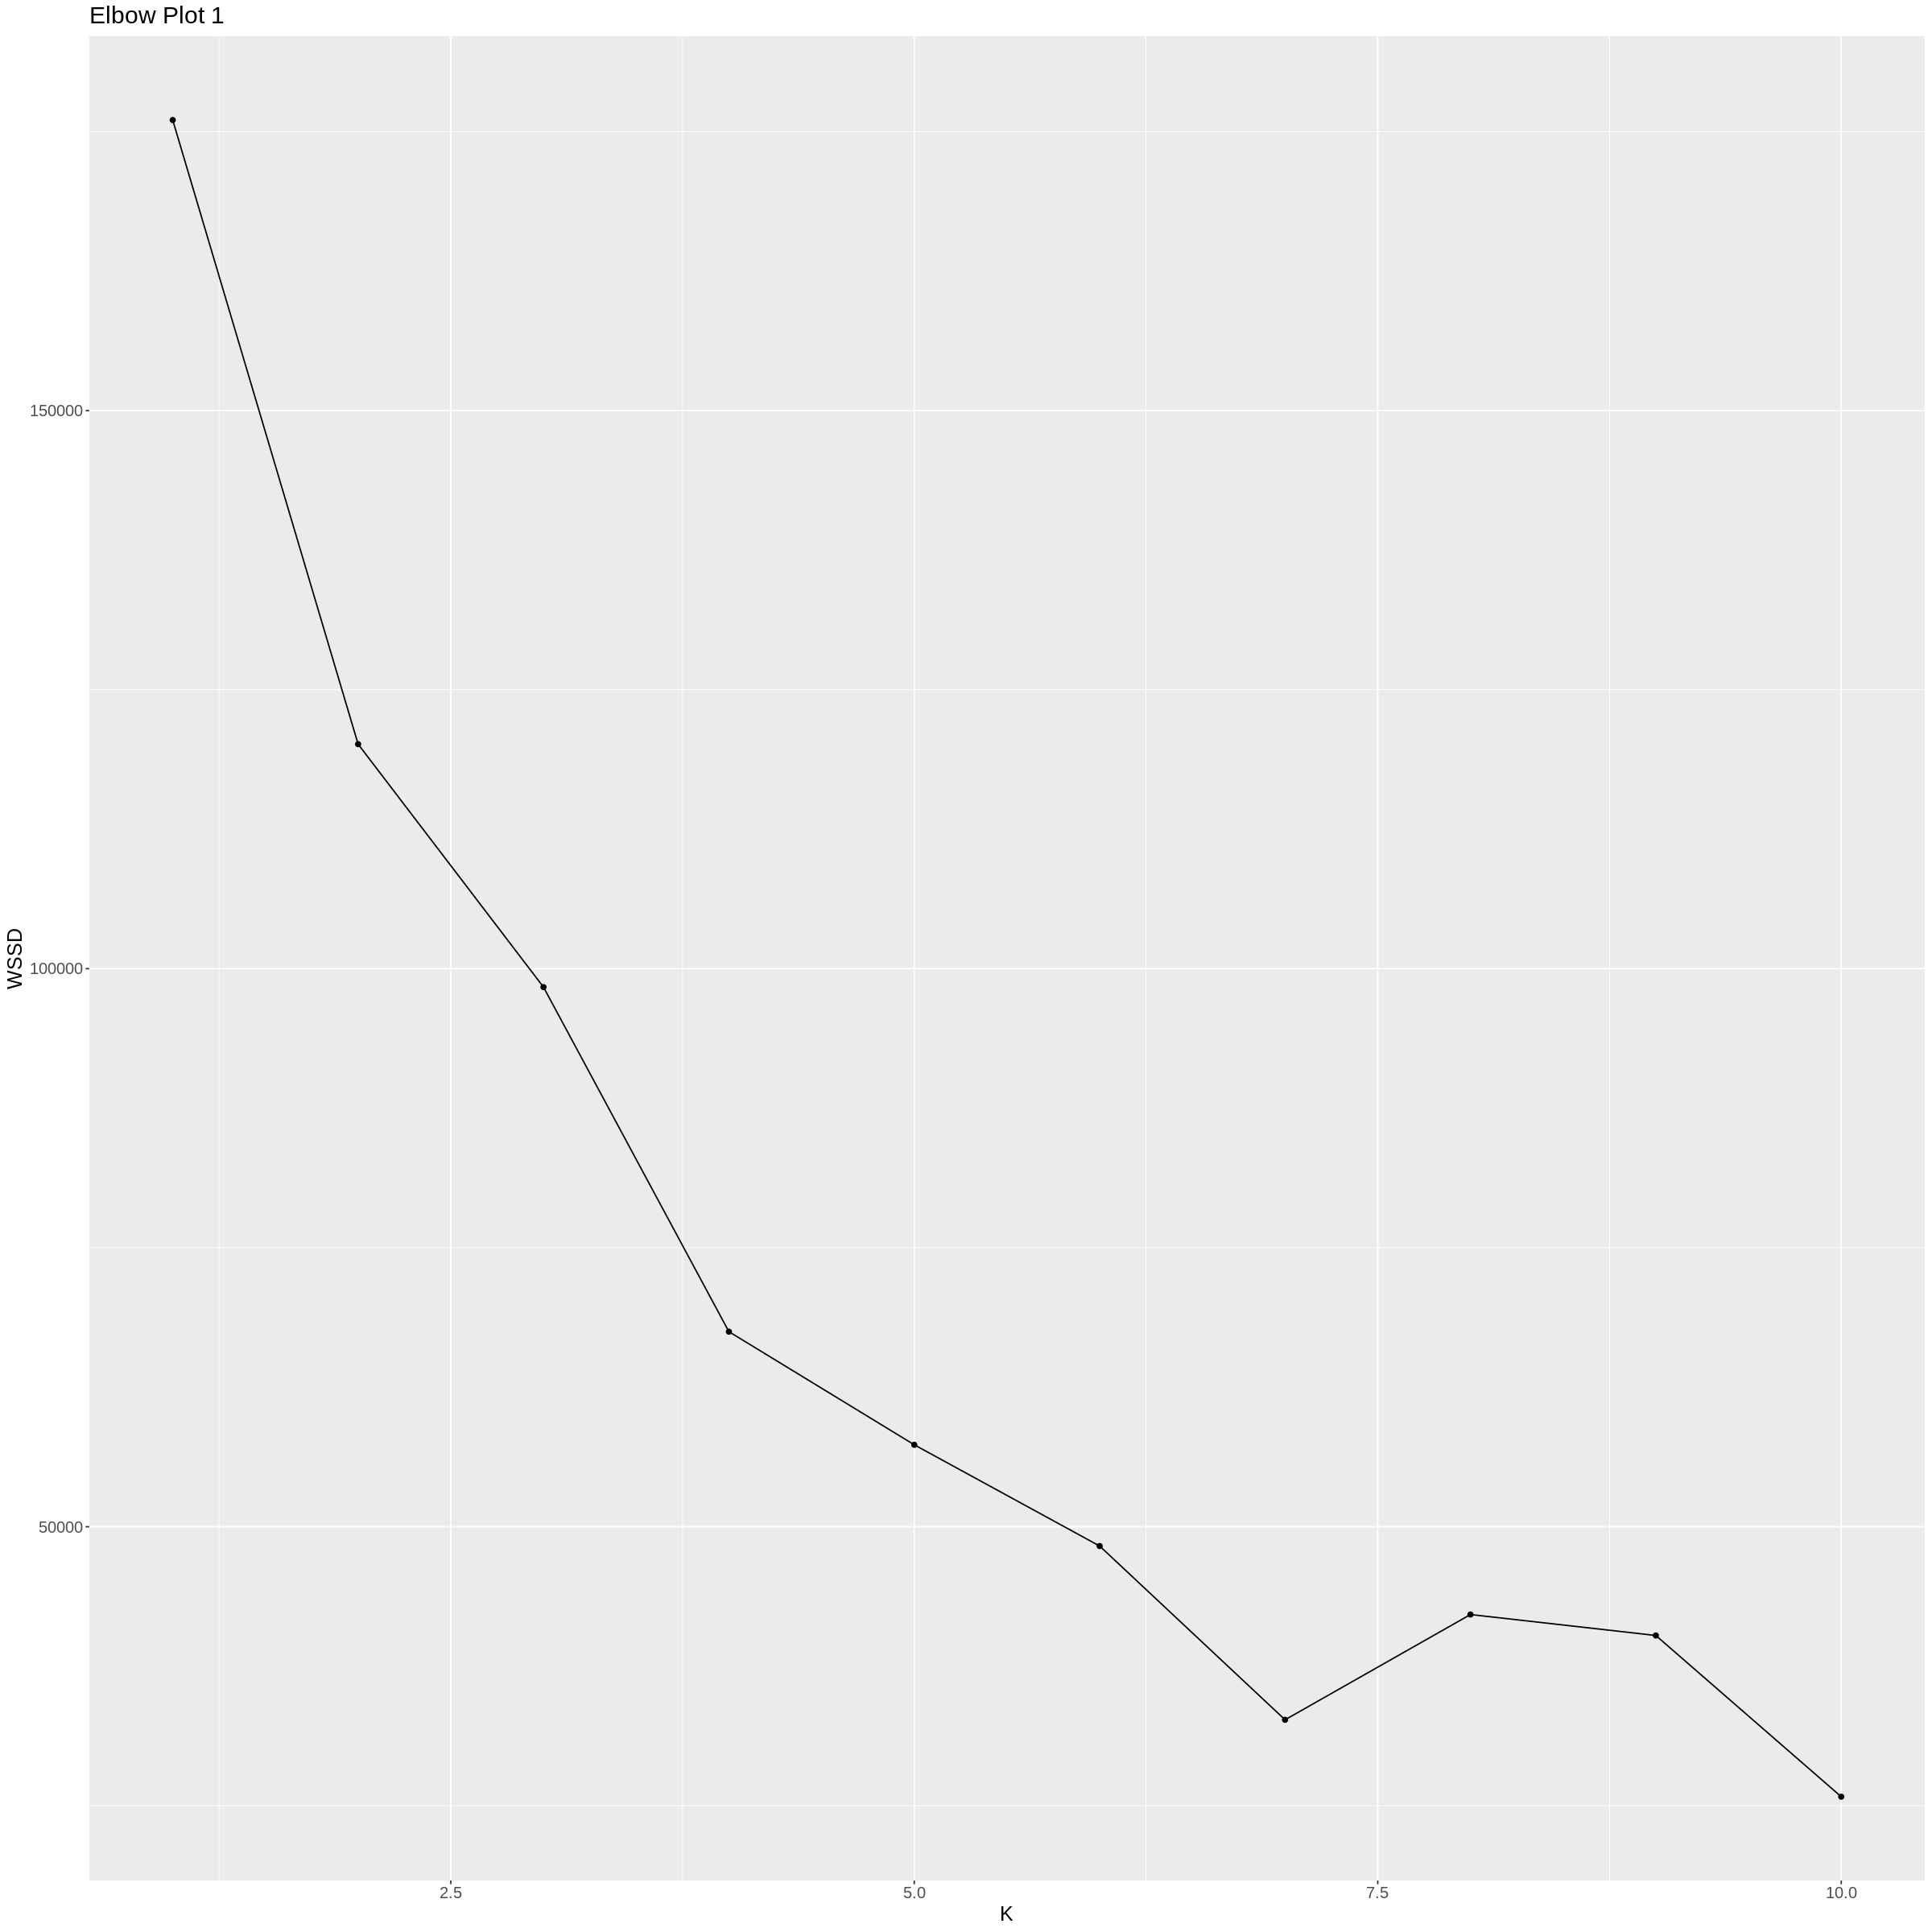

In [80]:
set.seed(9876)
#select for variables we want to cluster by
#then scale them
scaled_property_1 <- property_housing_only |>
    select(CURRENT_LAND_VALUE, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_1, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 1") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

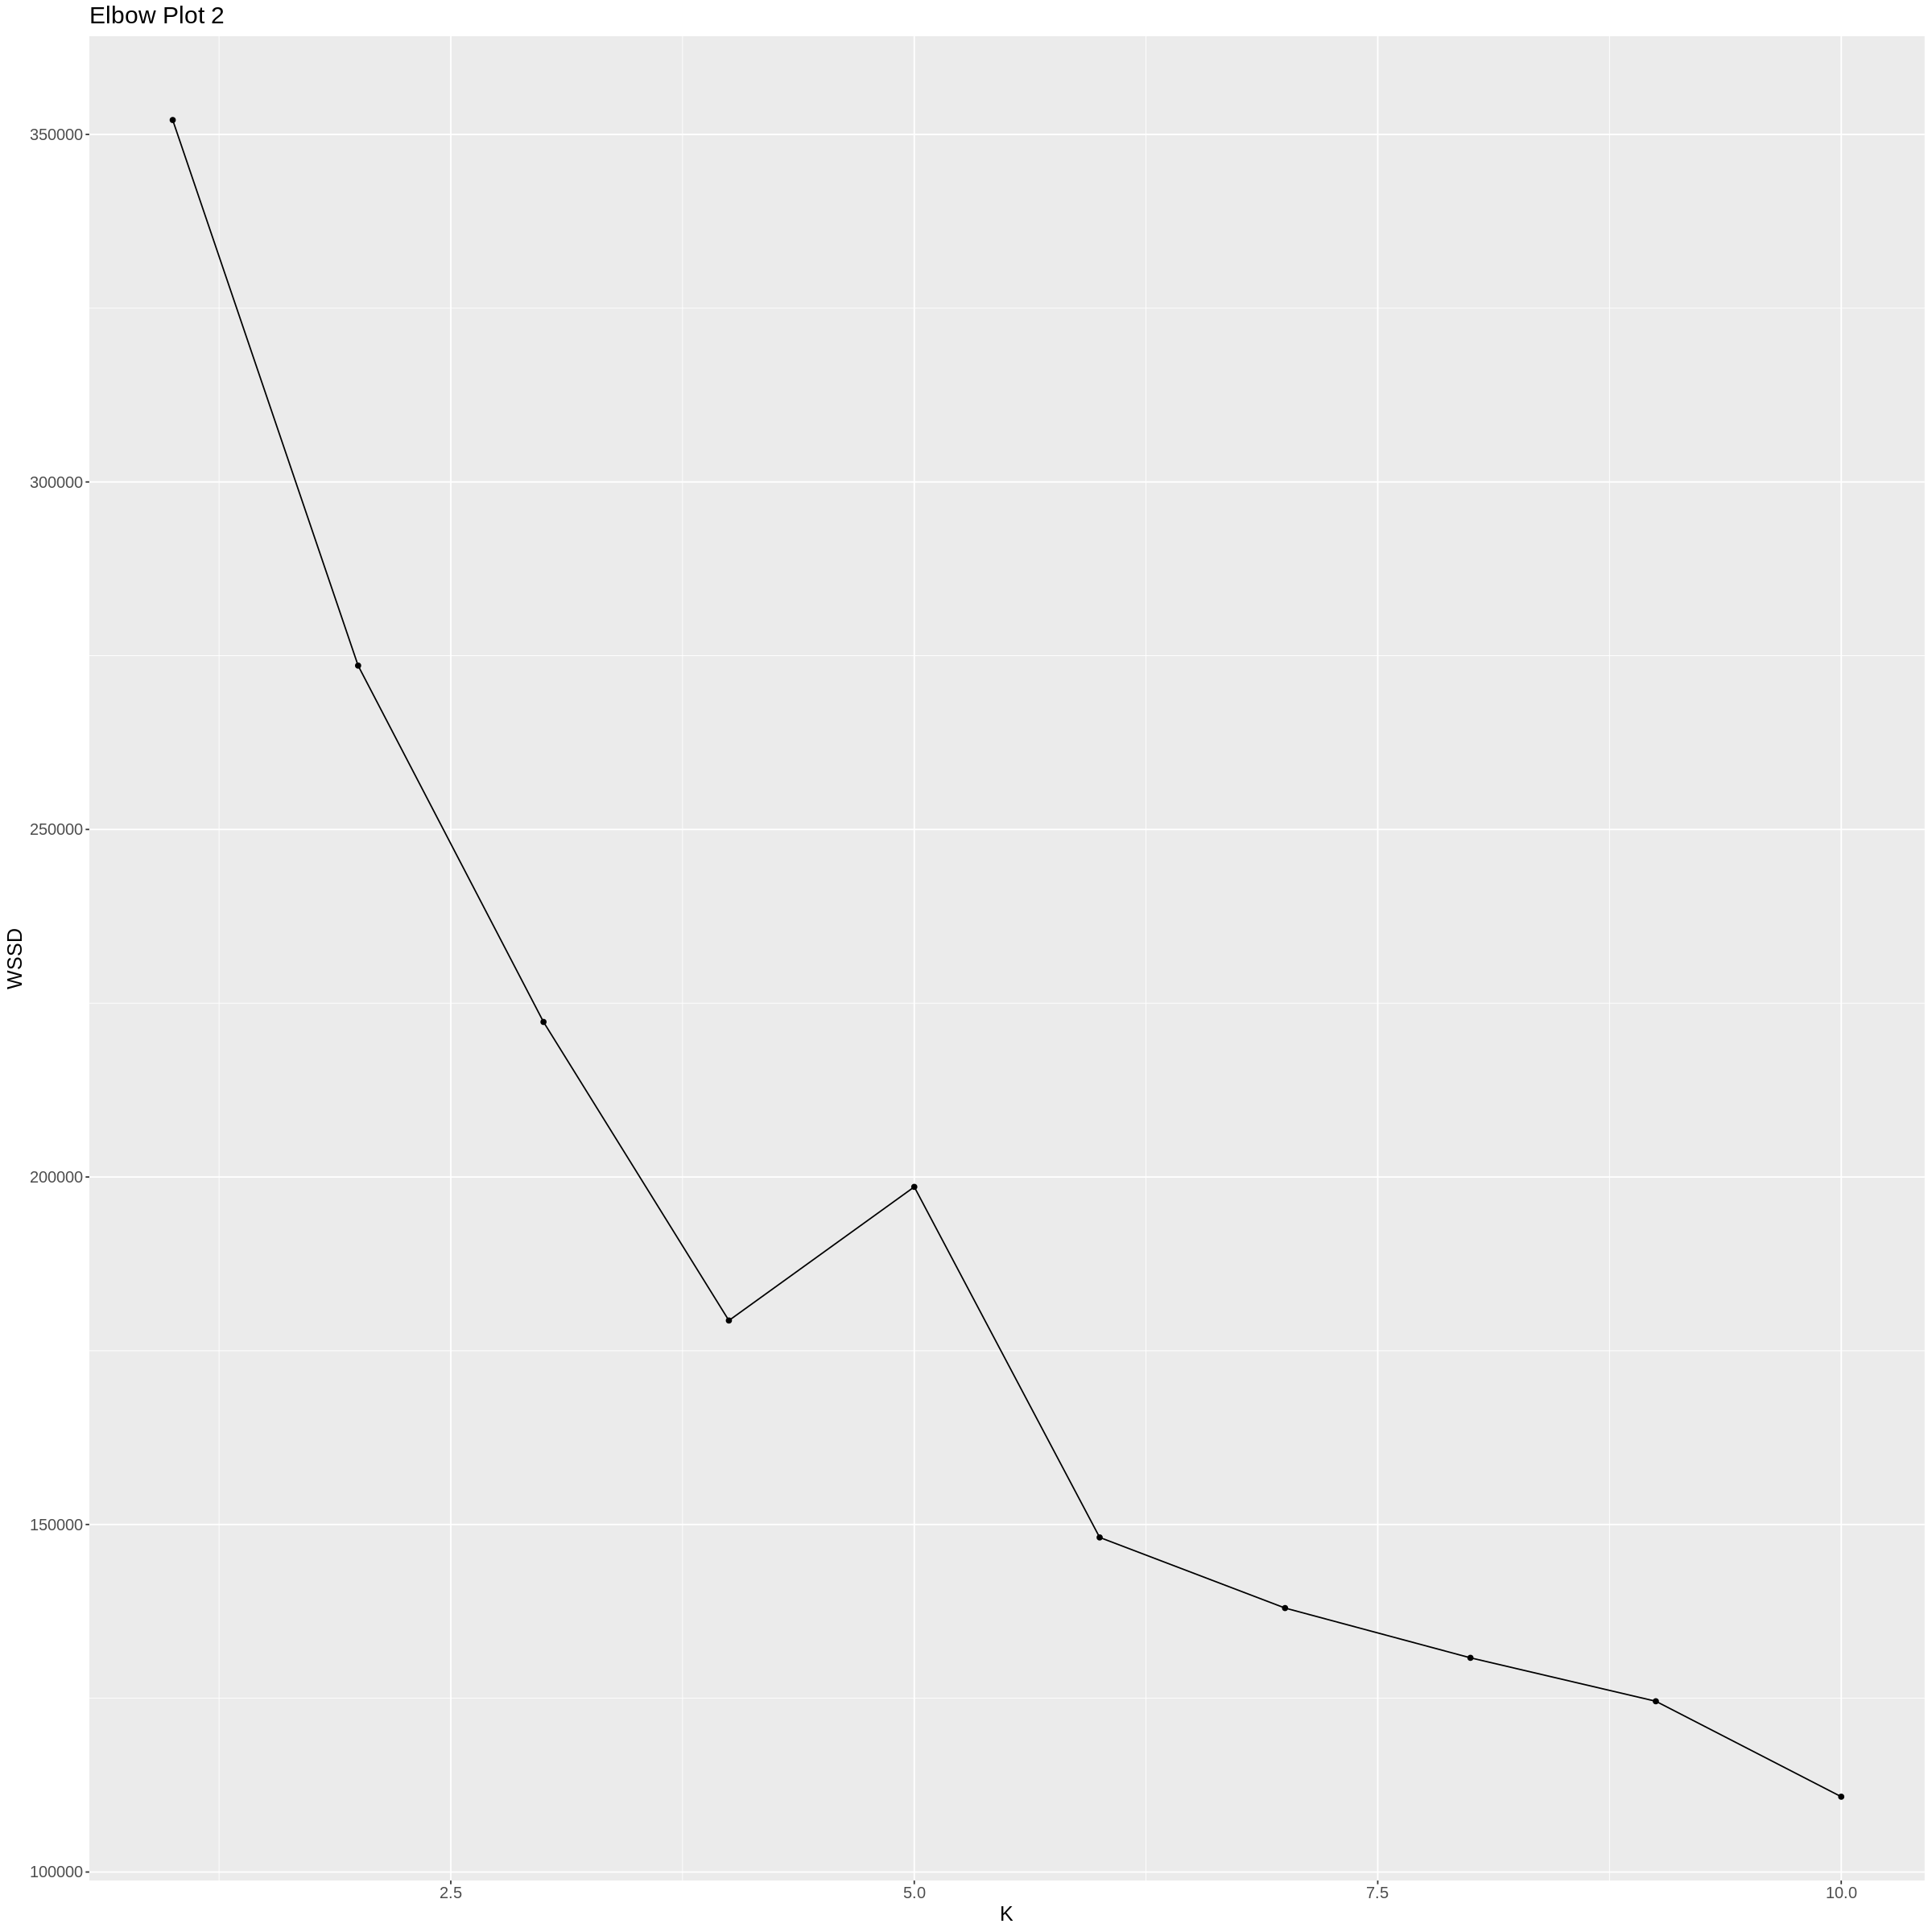

In [81]:
set.seed(9876)
scaled_property_2 <- property_housing_only |>
    select(CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, 
           YEAR_BUILT, BIG_IMPROVEMENT_YEAR, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_2, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 2") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4???

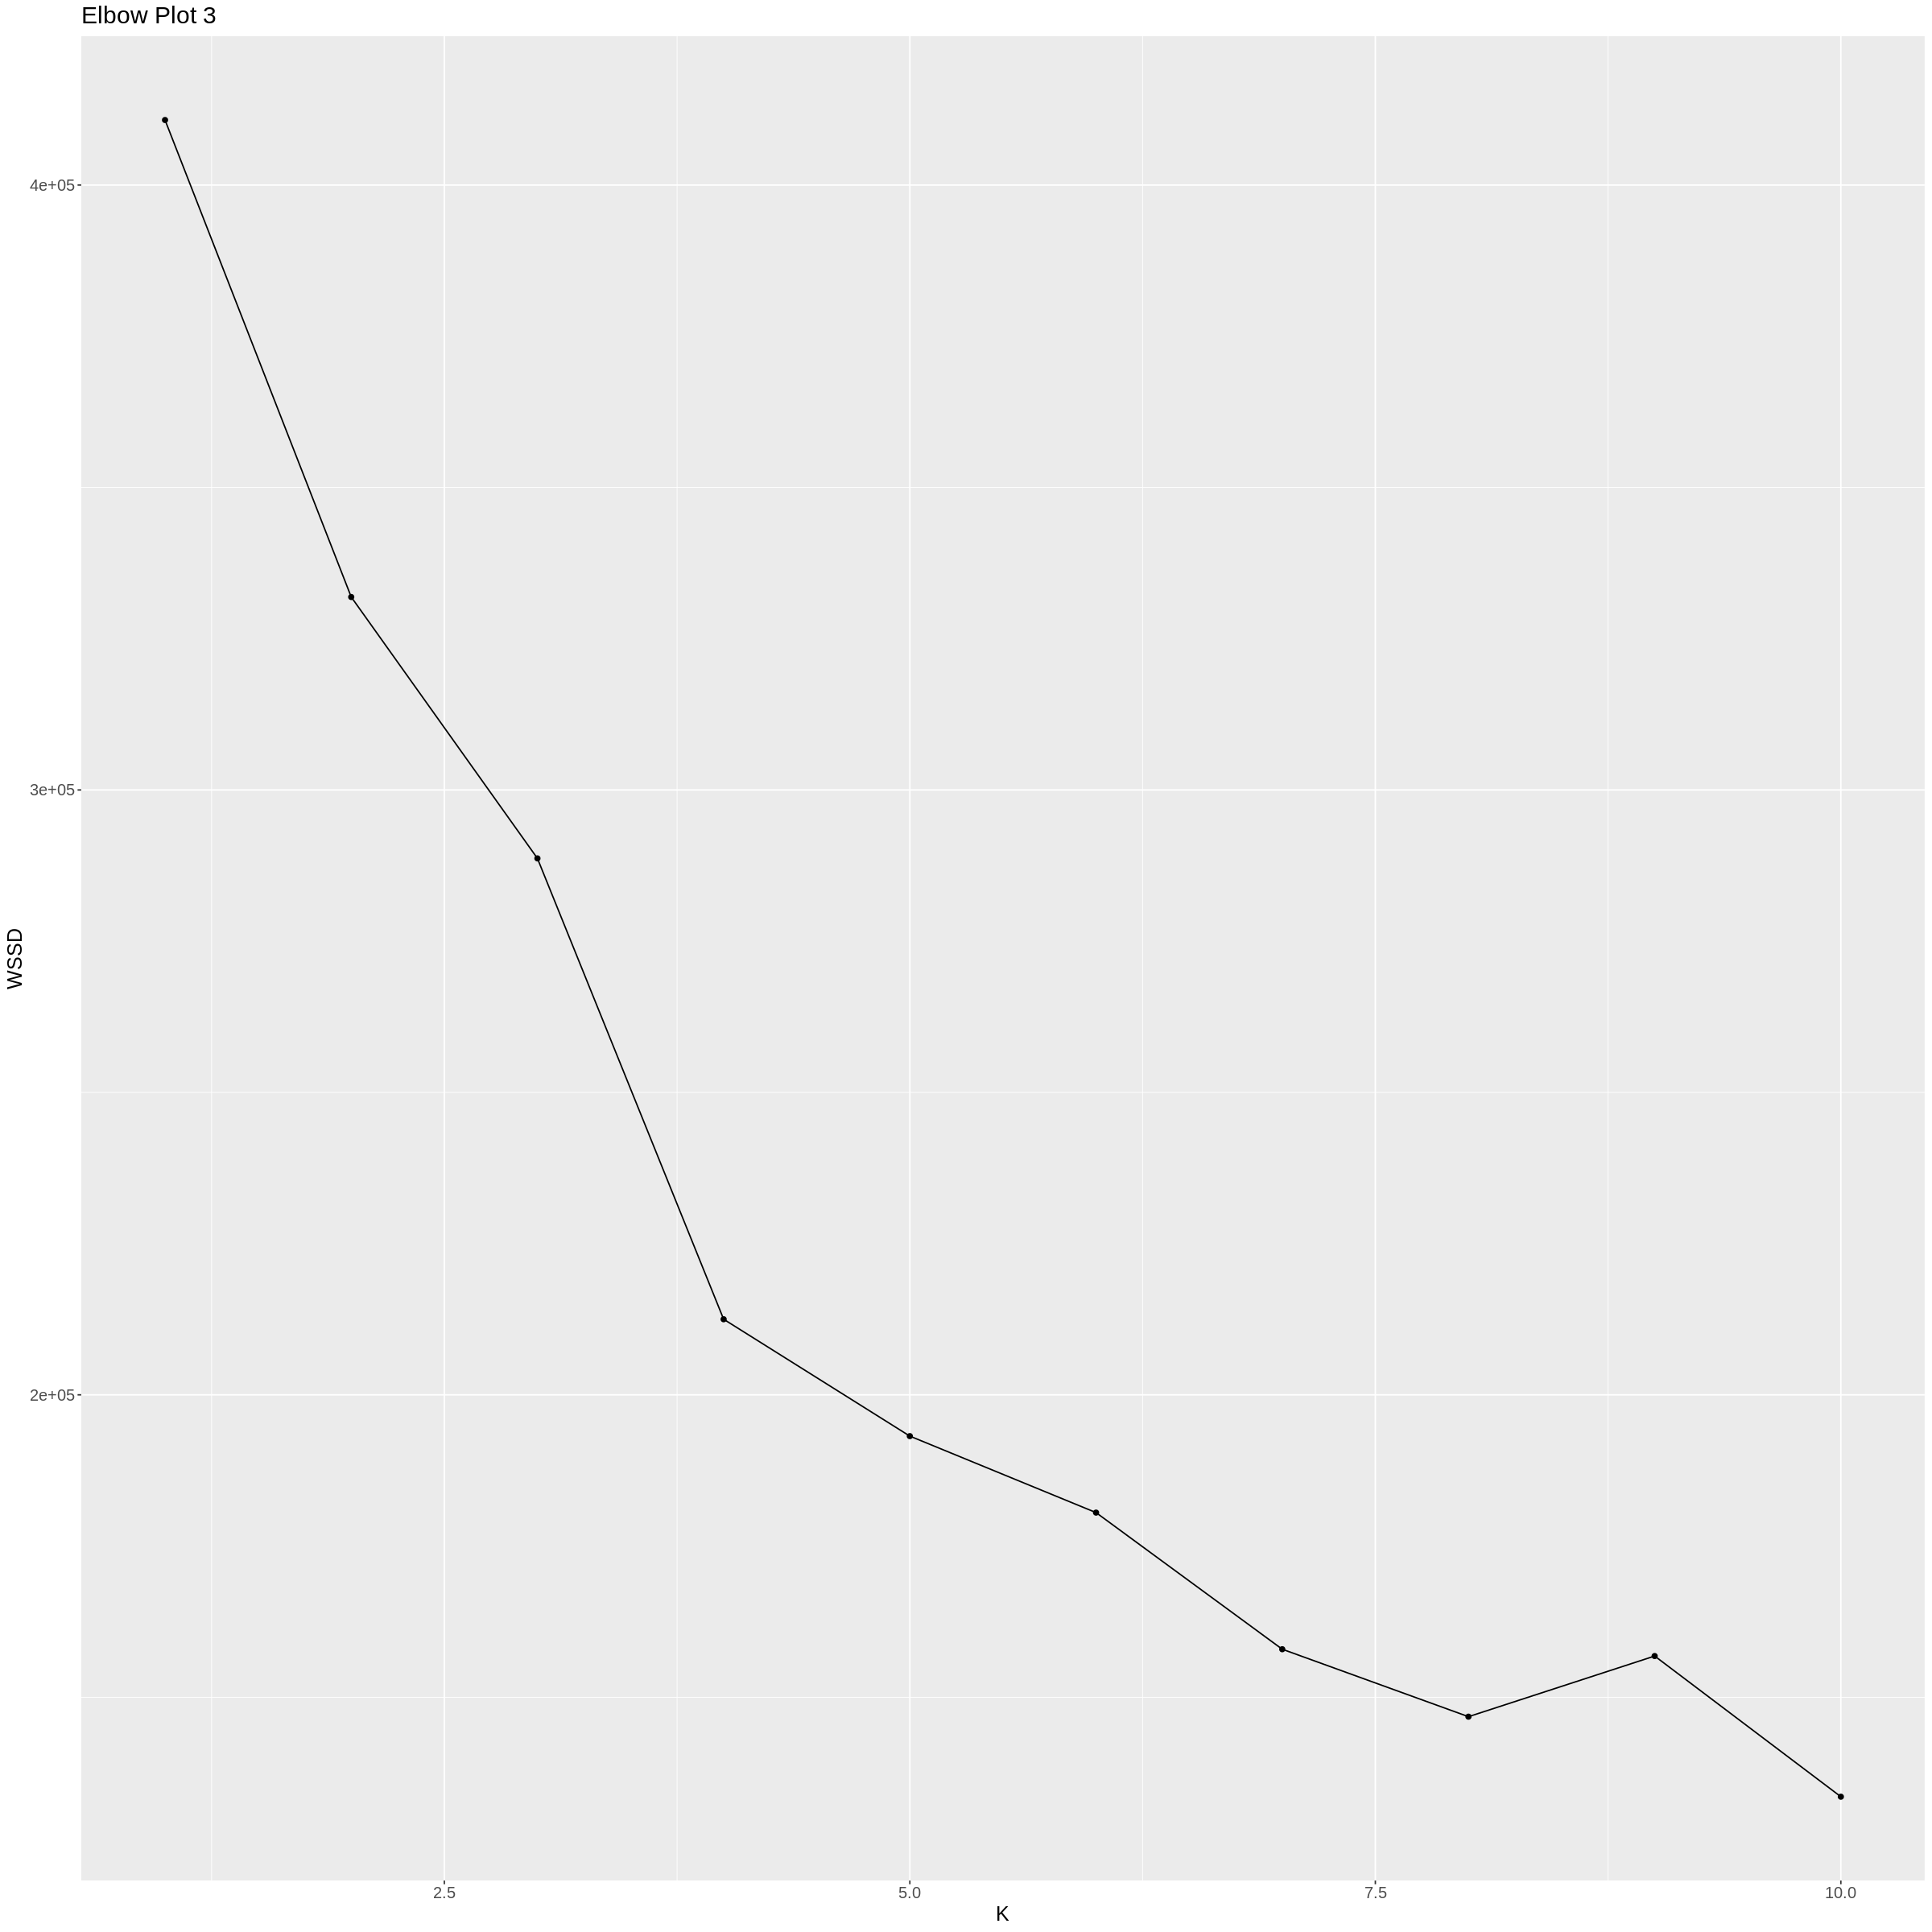

In [82]:
set.seed(9876)
scaled_property_3 <- property_housing_only |>
    select(CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, 
           YEAR_BUILT, BIG_IMPROVEMENT_YEAR, TAX_LEVY, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_3, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 3") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

<h2> </h2>

In [15]:
#BEYOND THIS POINT, WE ARE AGGREGATING APARTMENTS TOGETHER
#
#
#
#
#
#
#
#
#
#
#
#
#AND IT BEGINS

`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


lat      long      AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE
1 49.20338 -123.1291     2700                         8300                   
2 49.20404 -123.1358  3760000                       592800                   
3 49.20416 -123.1361  5852000                      1176000                   
4 49.20429 -123.0247     2700                         8300                   
5 49.20443 -123.0339 12831000                     47198000                   
6 49.20472 -123.1377  2892000                       921700                   
  MEAN_YEAR_BUILT MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY SAME_ADDRESS_ENTRIES
1 1998            1998                         489.620     1                  
2 1975            1975                        1100.348    11                  
3 1968            1968                       19982.700     1                  
4 1998            1998                         489.620     1                  
5 2022            2022                      170154.000     1                  
6 1986            1986                        1325.594     8

[1] "Same-address Property Value Entries: 27146  /  58680  total"


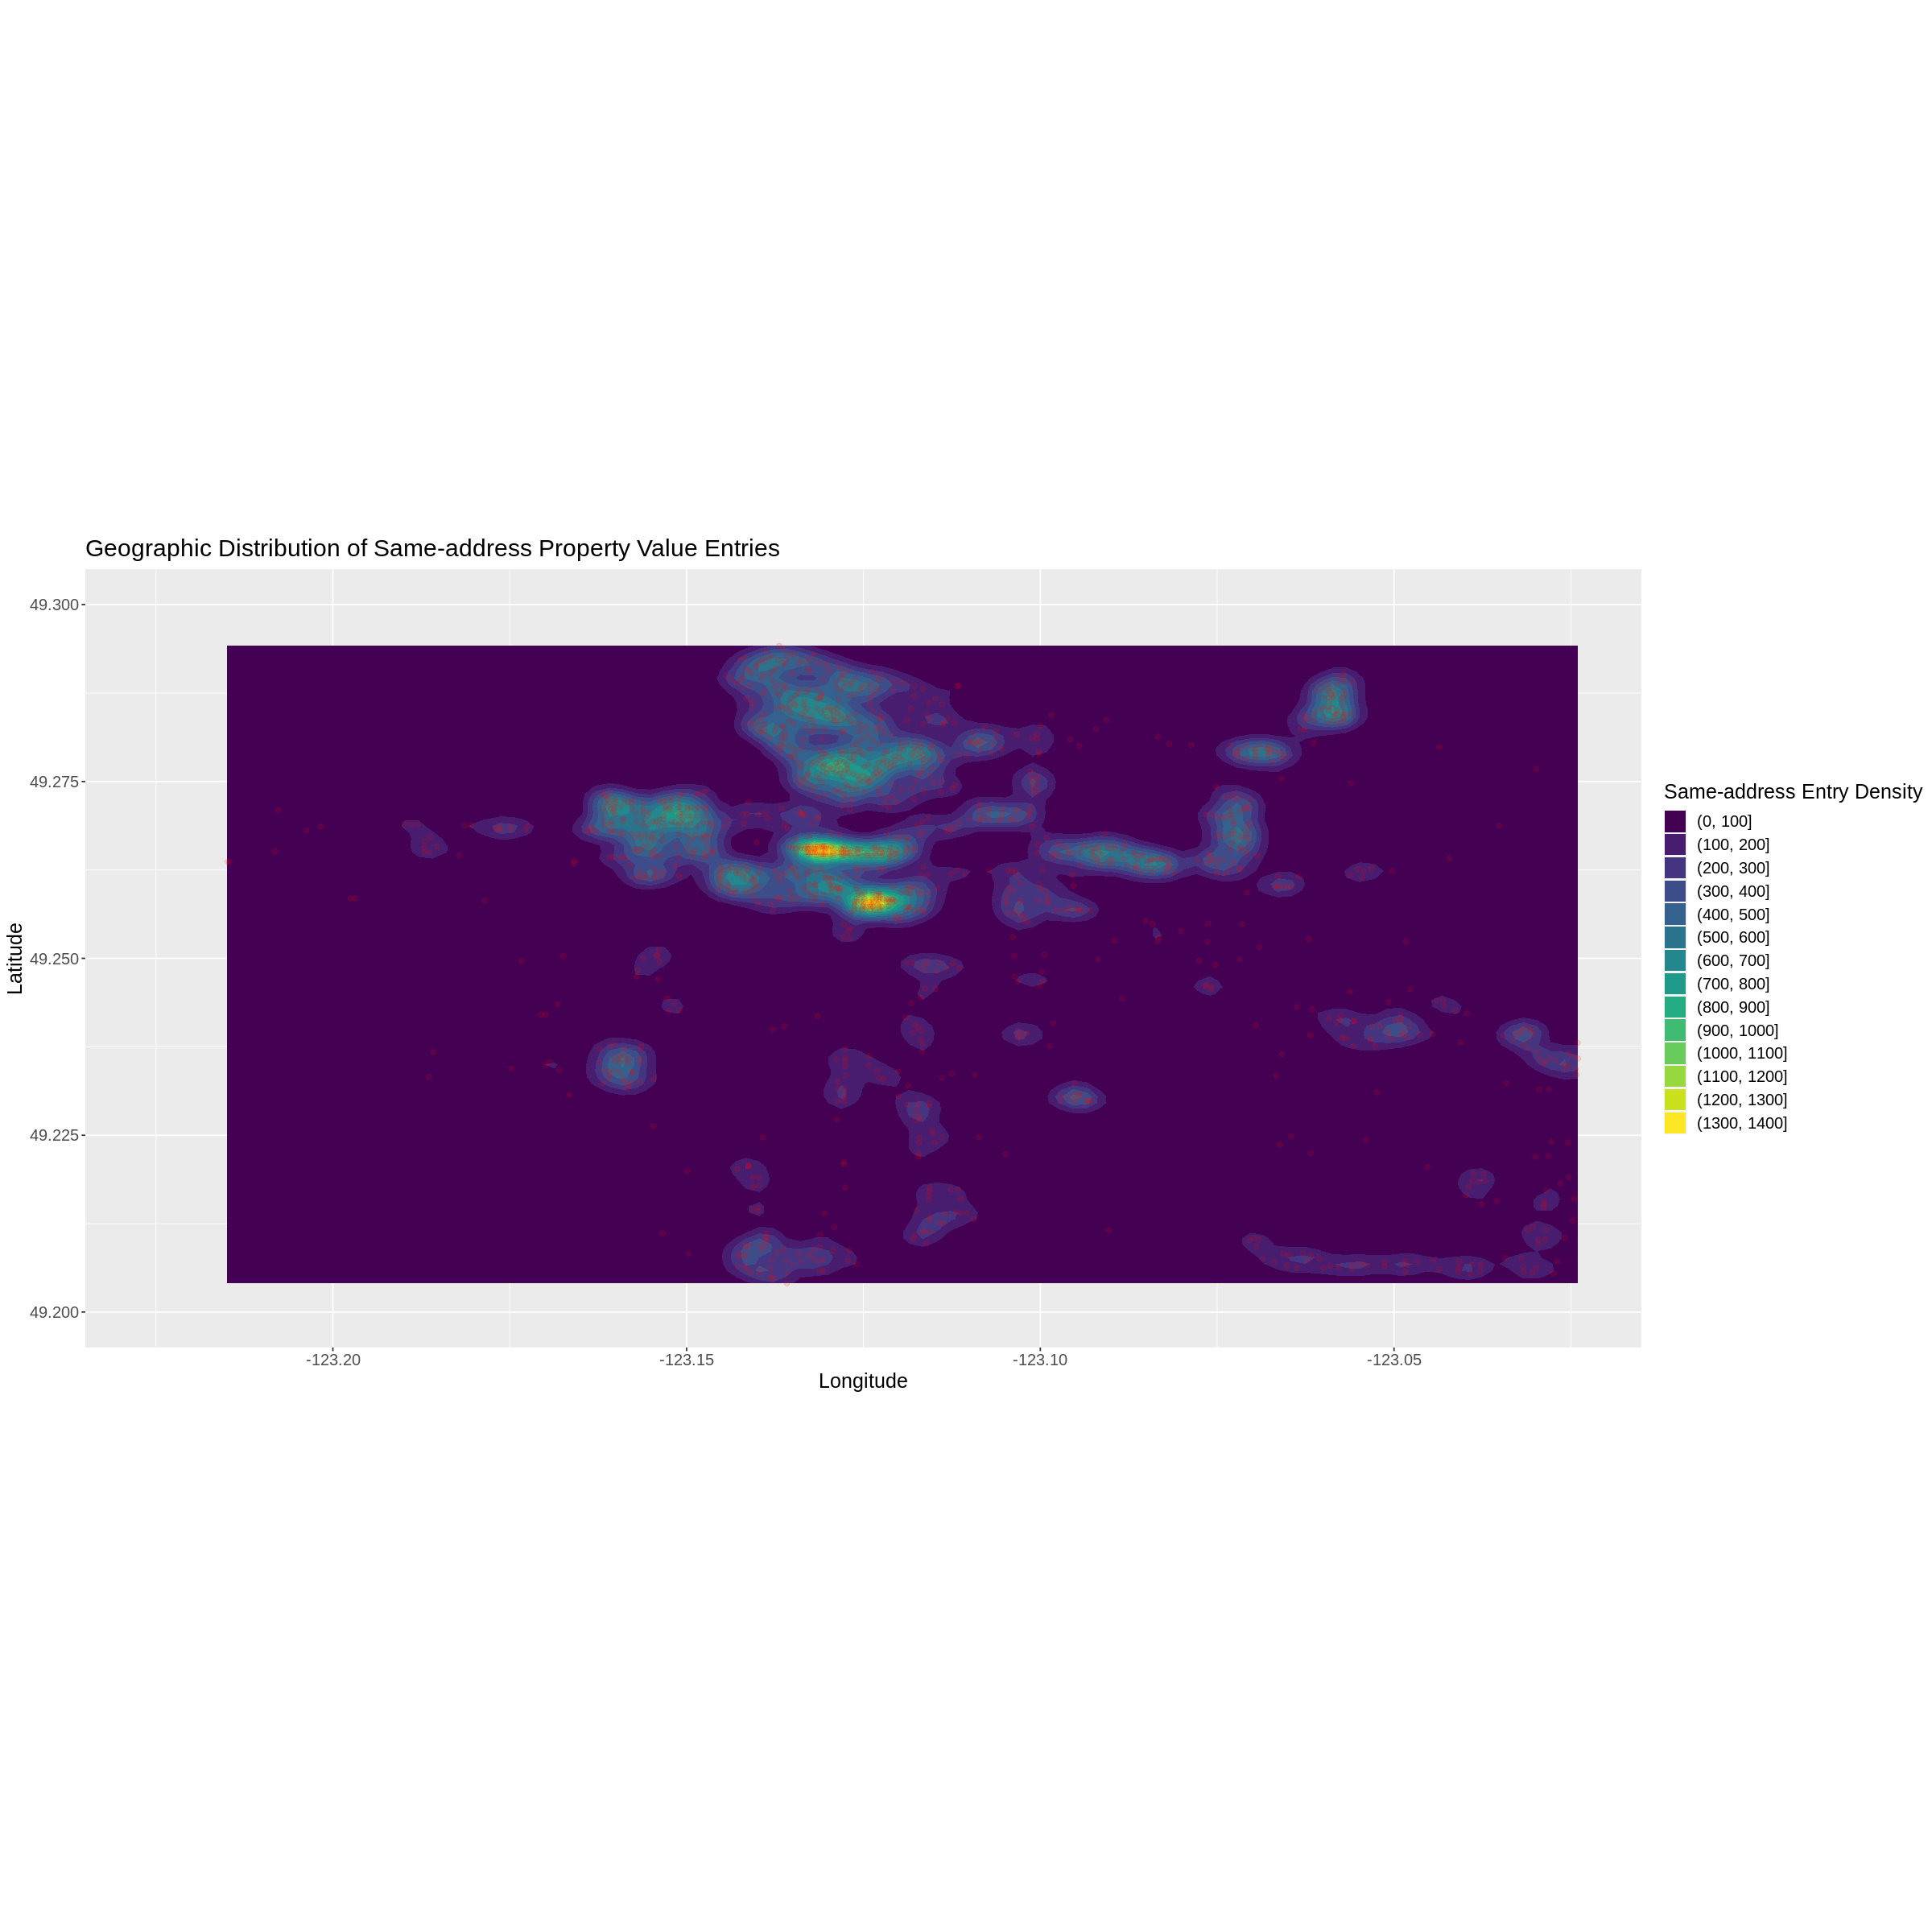

In [4]:
## Address Aggregation
# Find count of same-address property value entries by location

housing_aggregated <- property_housing_only |>
                        group_by(lat, long) |>
                        arrange(long) |>
                        summarize(AGGREGATE_CURRENT_LAND_VALUE = sum(CURRENT_LAND_VALUE),
                                  AGGREGATE_IMPROVEMENT_VALUE = sum(CURRENT_IMPROVEMENT_VALUE),
                                  MEAN_YEAR_BUILT = mean(YEAR_BUILT),
                                  MEAN_BIG_IMPROVEMENT_YEAR = mean(BIG_IMPROVEMENT_YEAR),
                                  MEAN_TAX_LEVY = mean(TAX_LEVY),
                                  SAME_ADDRESS_ENTRIES = n()) |>
                        as_tibble() #need it to be a tibble (originally a grouped df)
head(housing_aggregated)

print(paste("Same-address Property Value Entries:", nrow(housing_aggregated), " / ", nrow(property_housing_only), " total"))

# Plot Geographic distribution of Same-Address Property Tax Report Entries
options(repr.plot.width = 20, repr.plot.height =20)
property_plot <- housing_aggregated |>
                filter(SAME_ADDRESS_ENTRIES > 1) |>
                ggplot(aes(x=long,y=lat, z= SAME_ADDRESS_ENTRIES)) +
                geom_density_2d_filled(adjust = 1/4) +
                geom_point(alpha = 0.125, color = "red") +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     fill = "Same-address Entry Density", 
                     title = "Geographic Distribution of Same-address Property Value Entries") +
                theme(text = element_text(size = 15))
property_plot

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


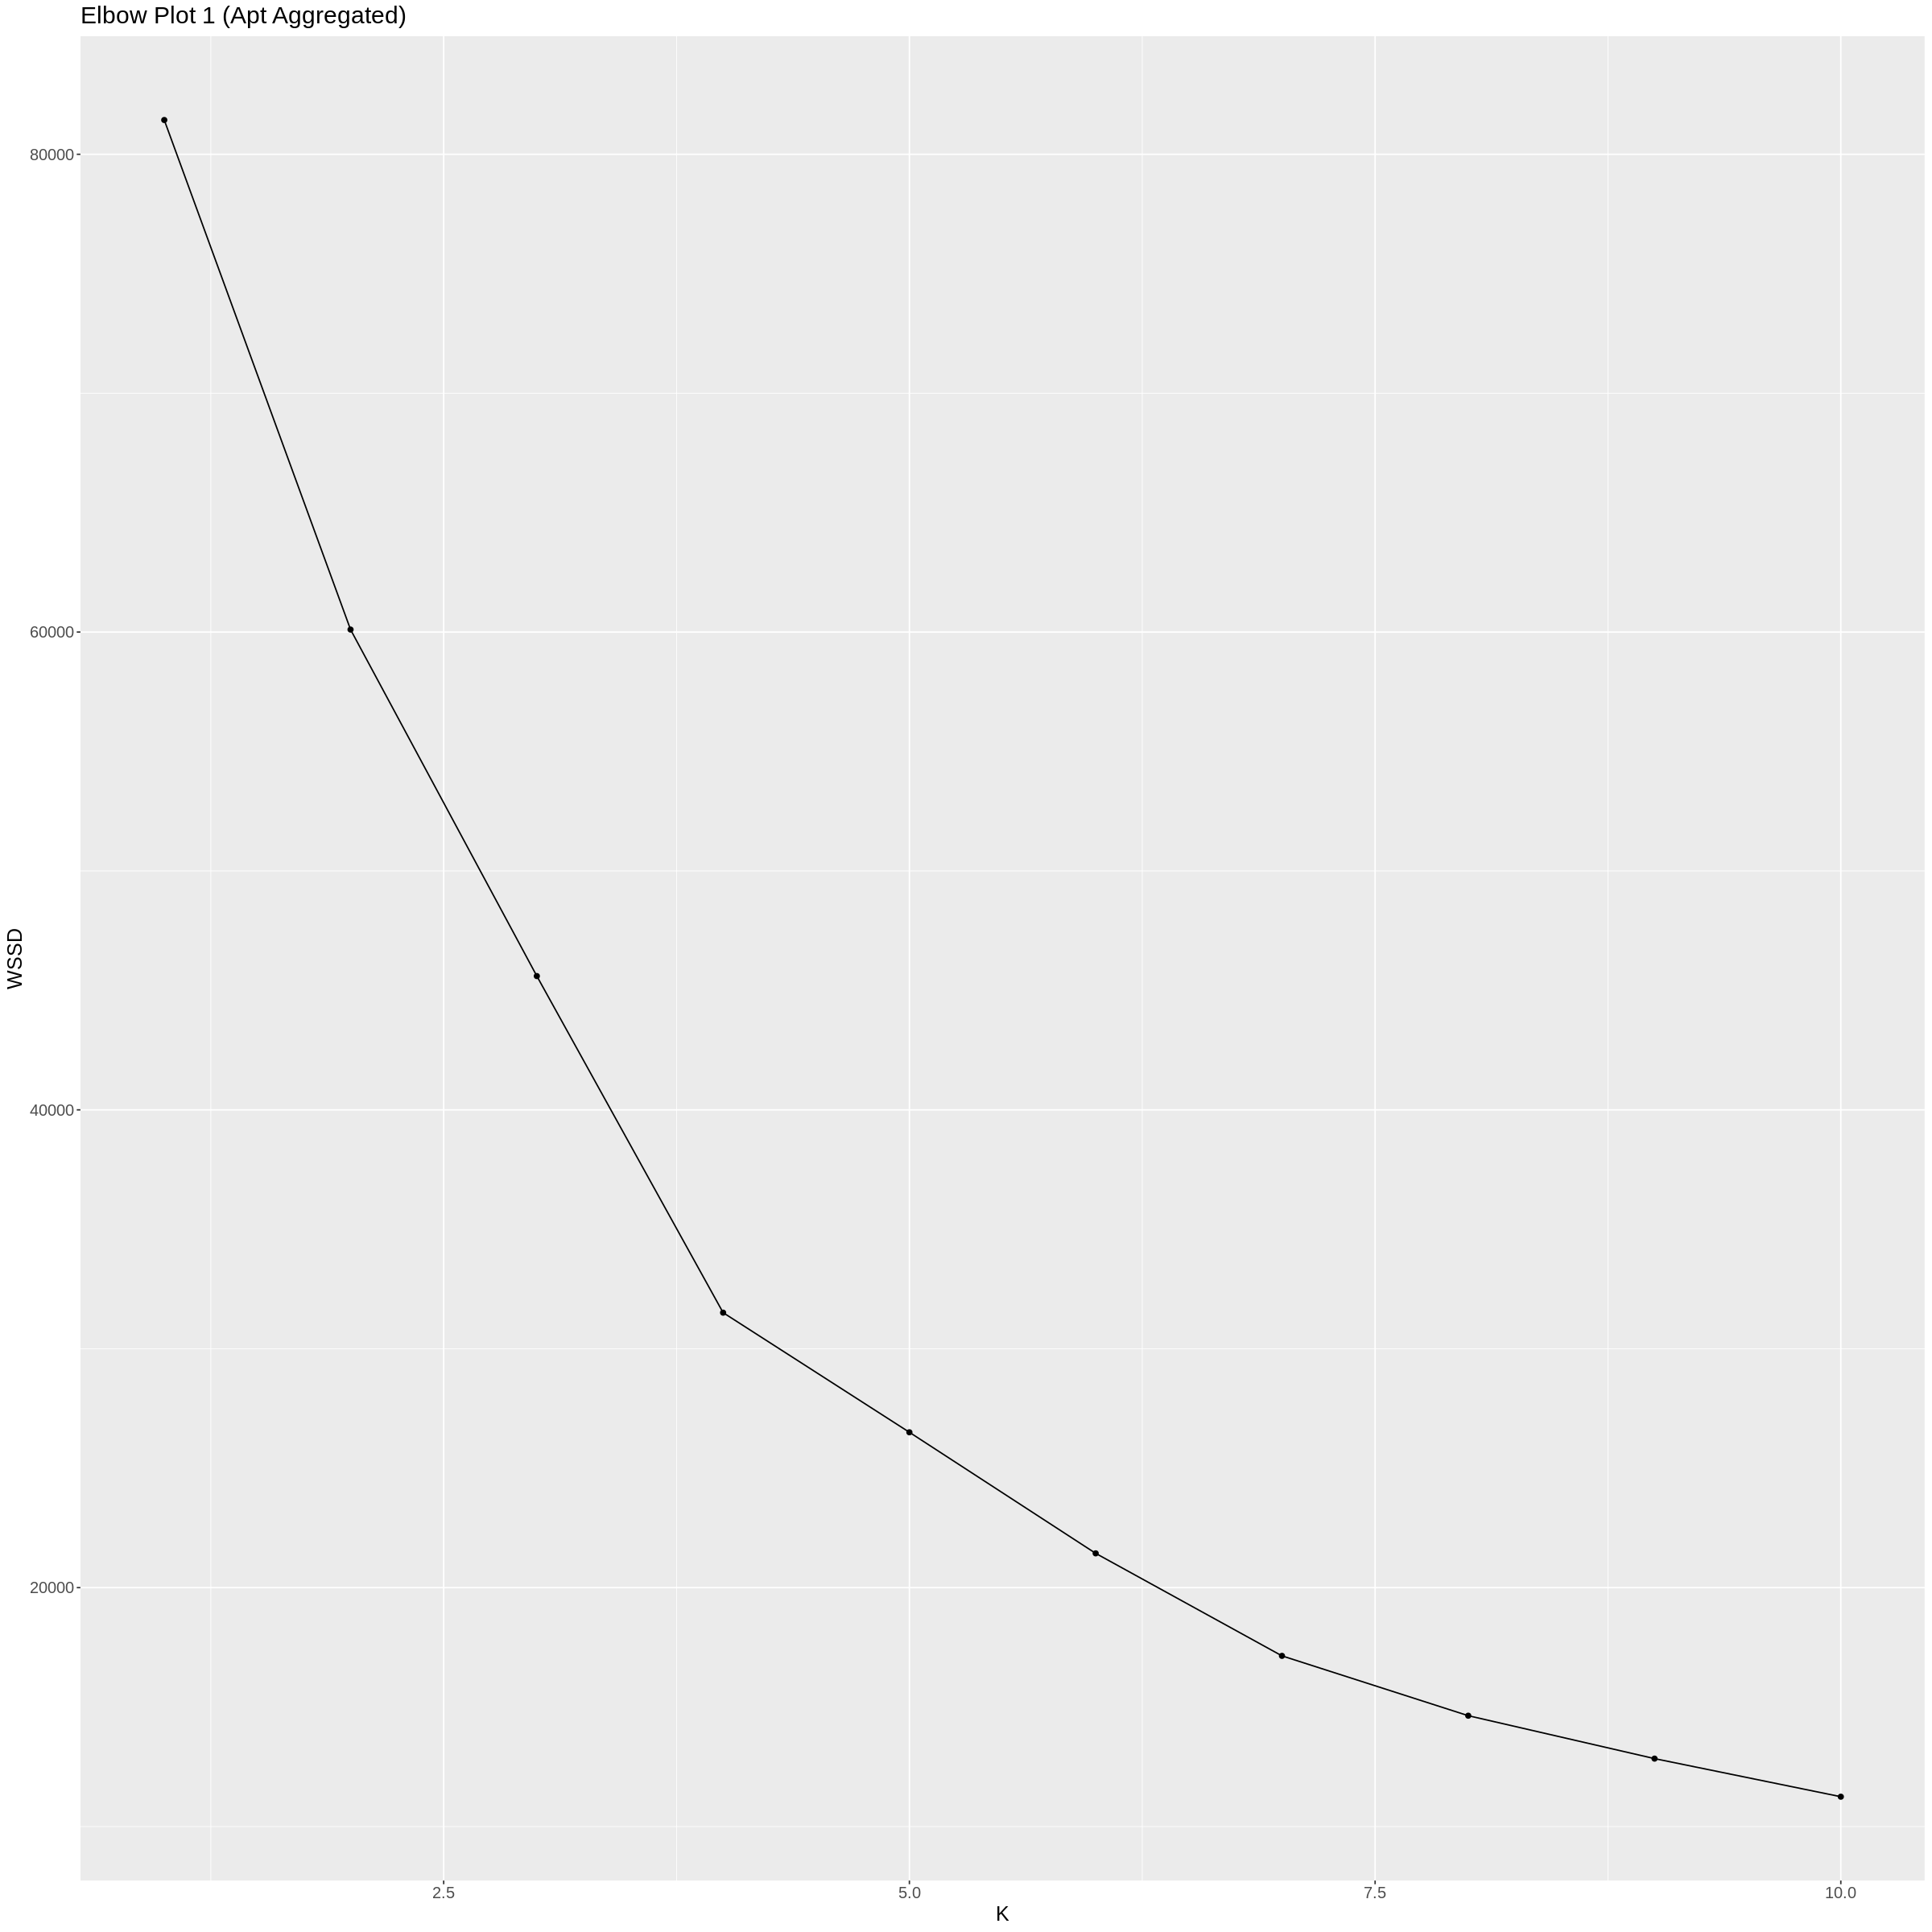

In [83]:
set.seed(9876)
#select for variables we want to cluster by
#then scale them
scaled_property_agg_1 <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_1, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 1 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


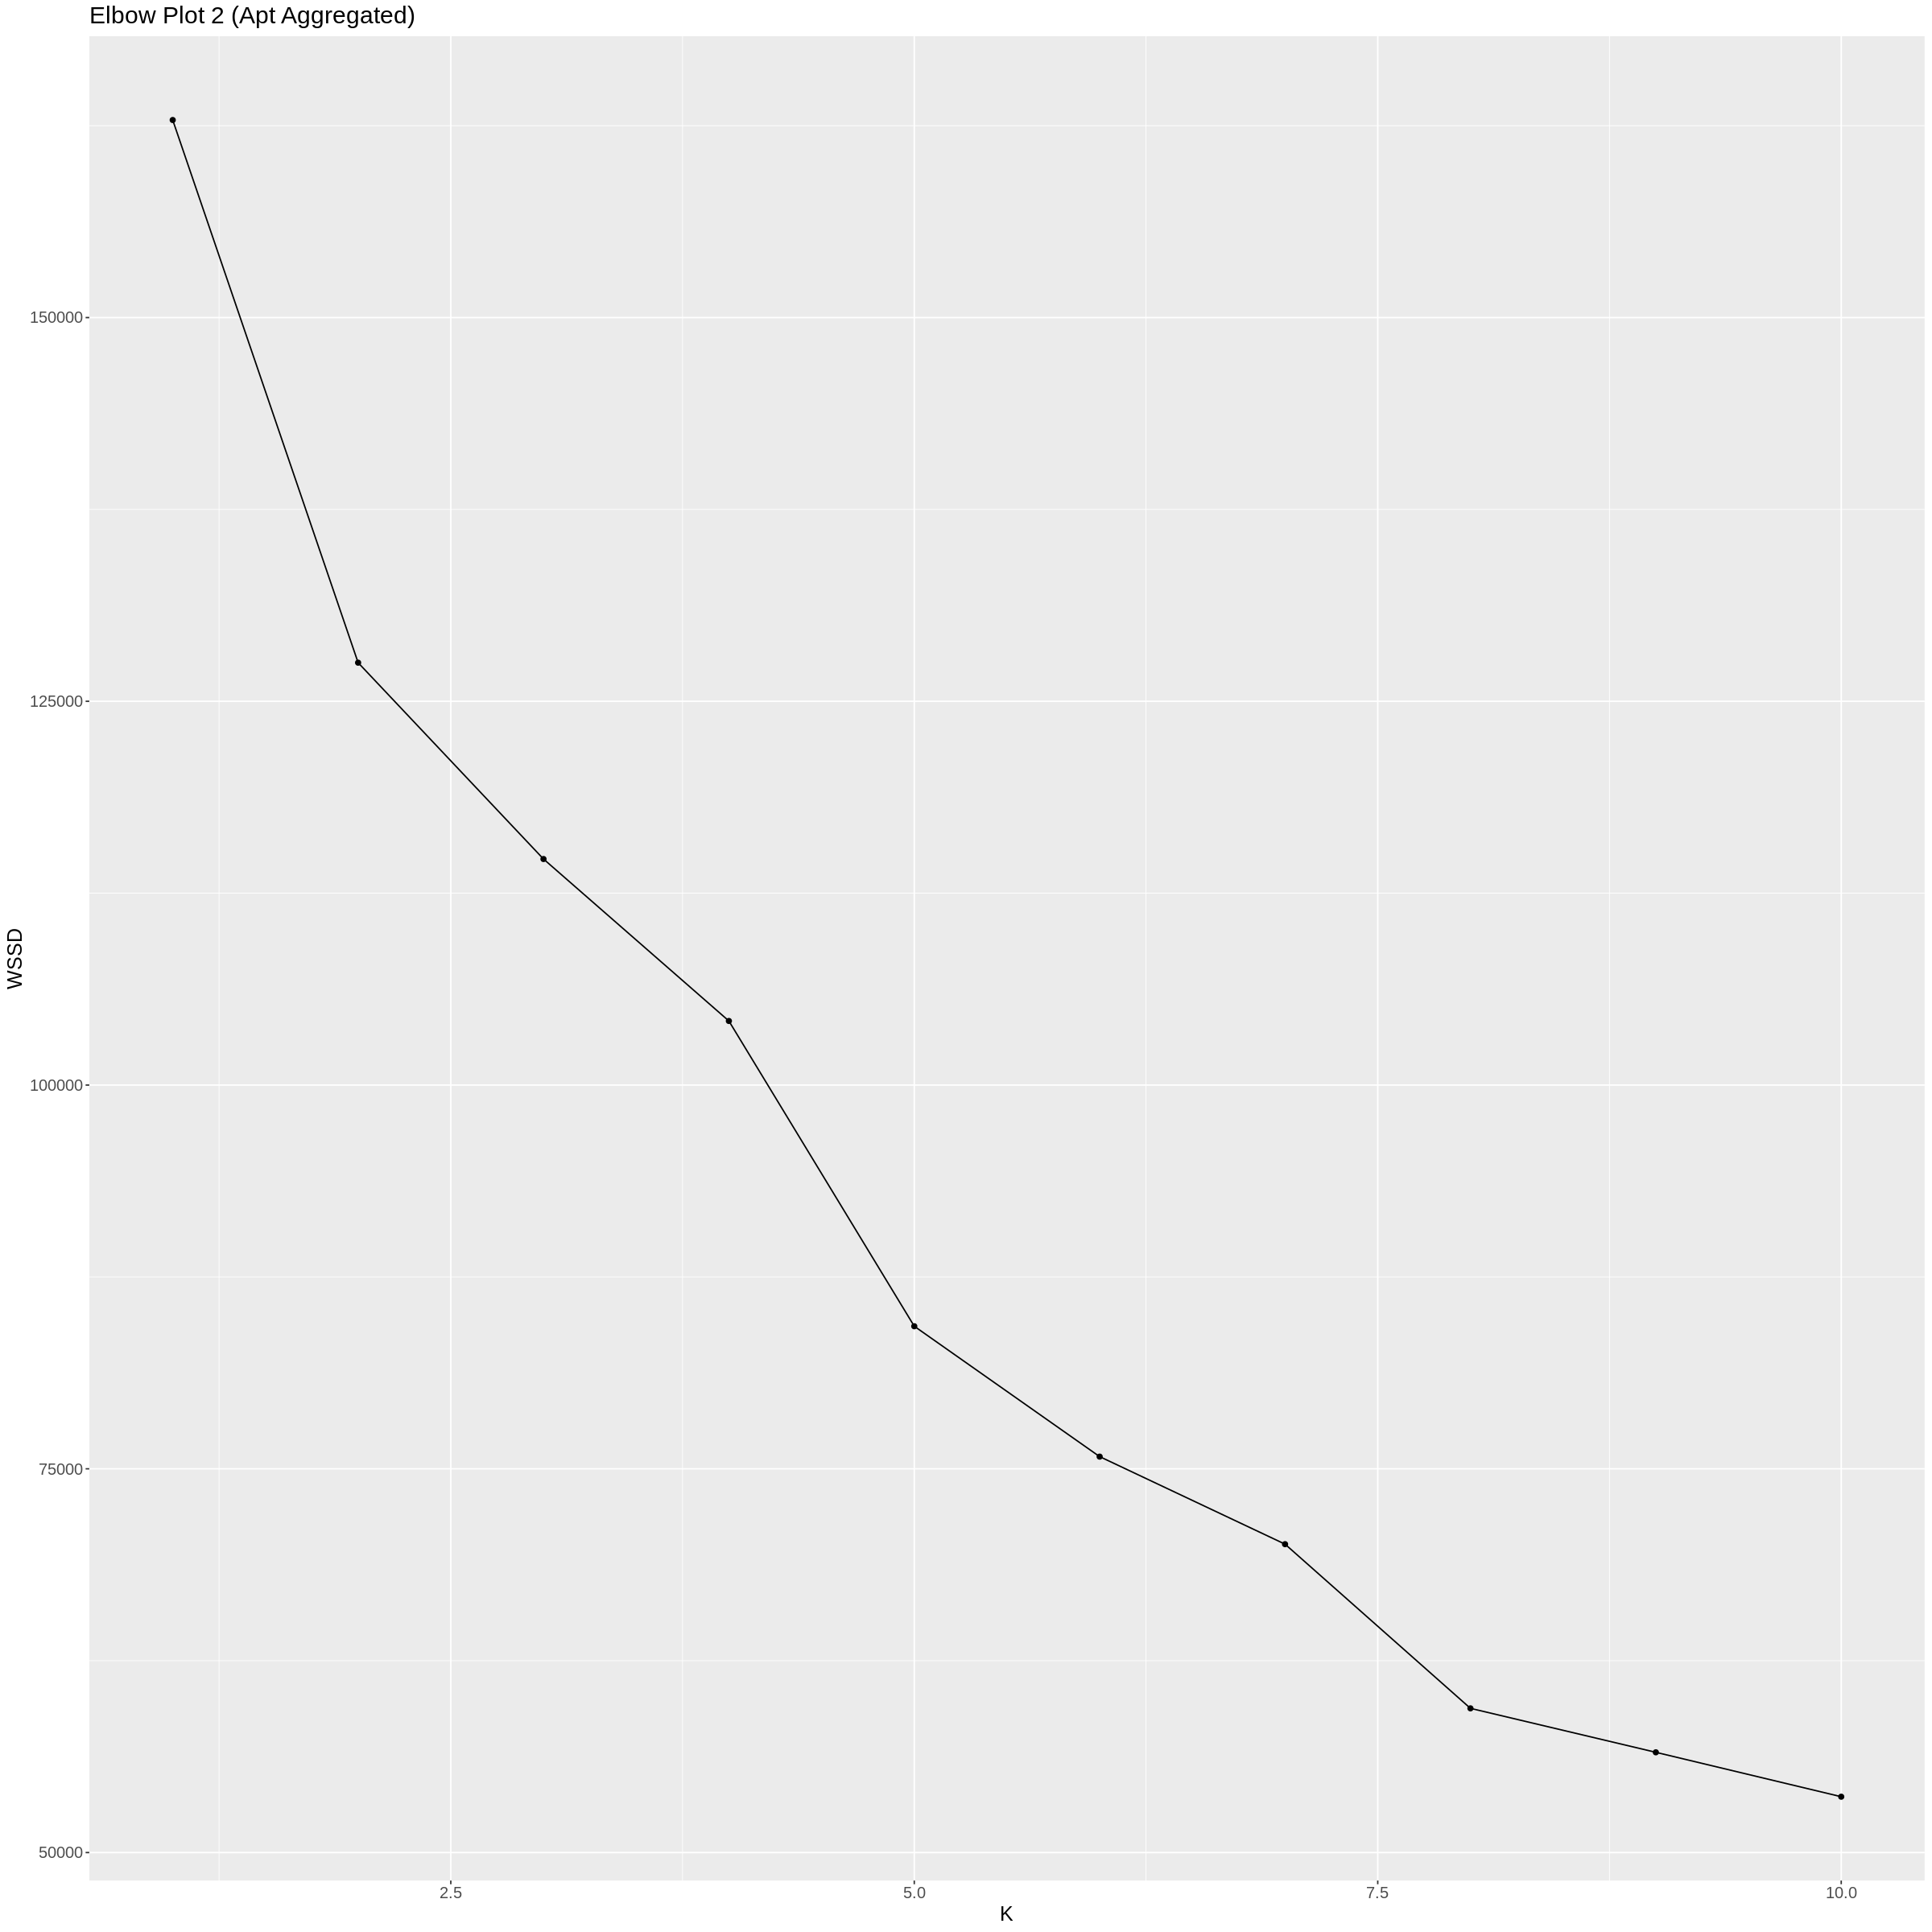

In [119]:
set.seed(9876)
scaled_property_agg_2 <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, AGGREGATE_IMPROVEMENT_VALUE,
           MEAN_YEAR_BUILT, MEAN_BIG_IMPROVEMENT_YEAR, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_2, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 2 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4???

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


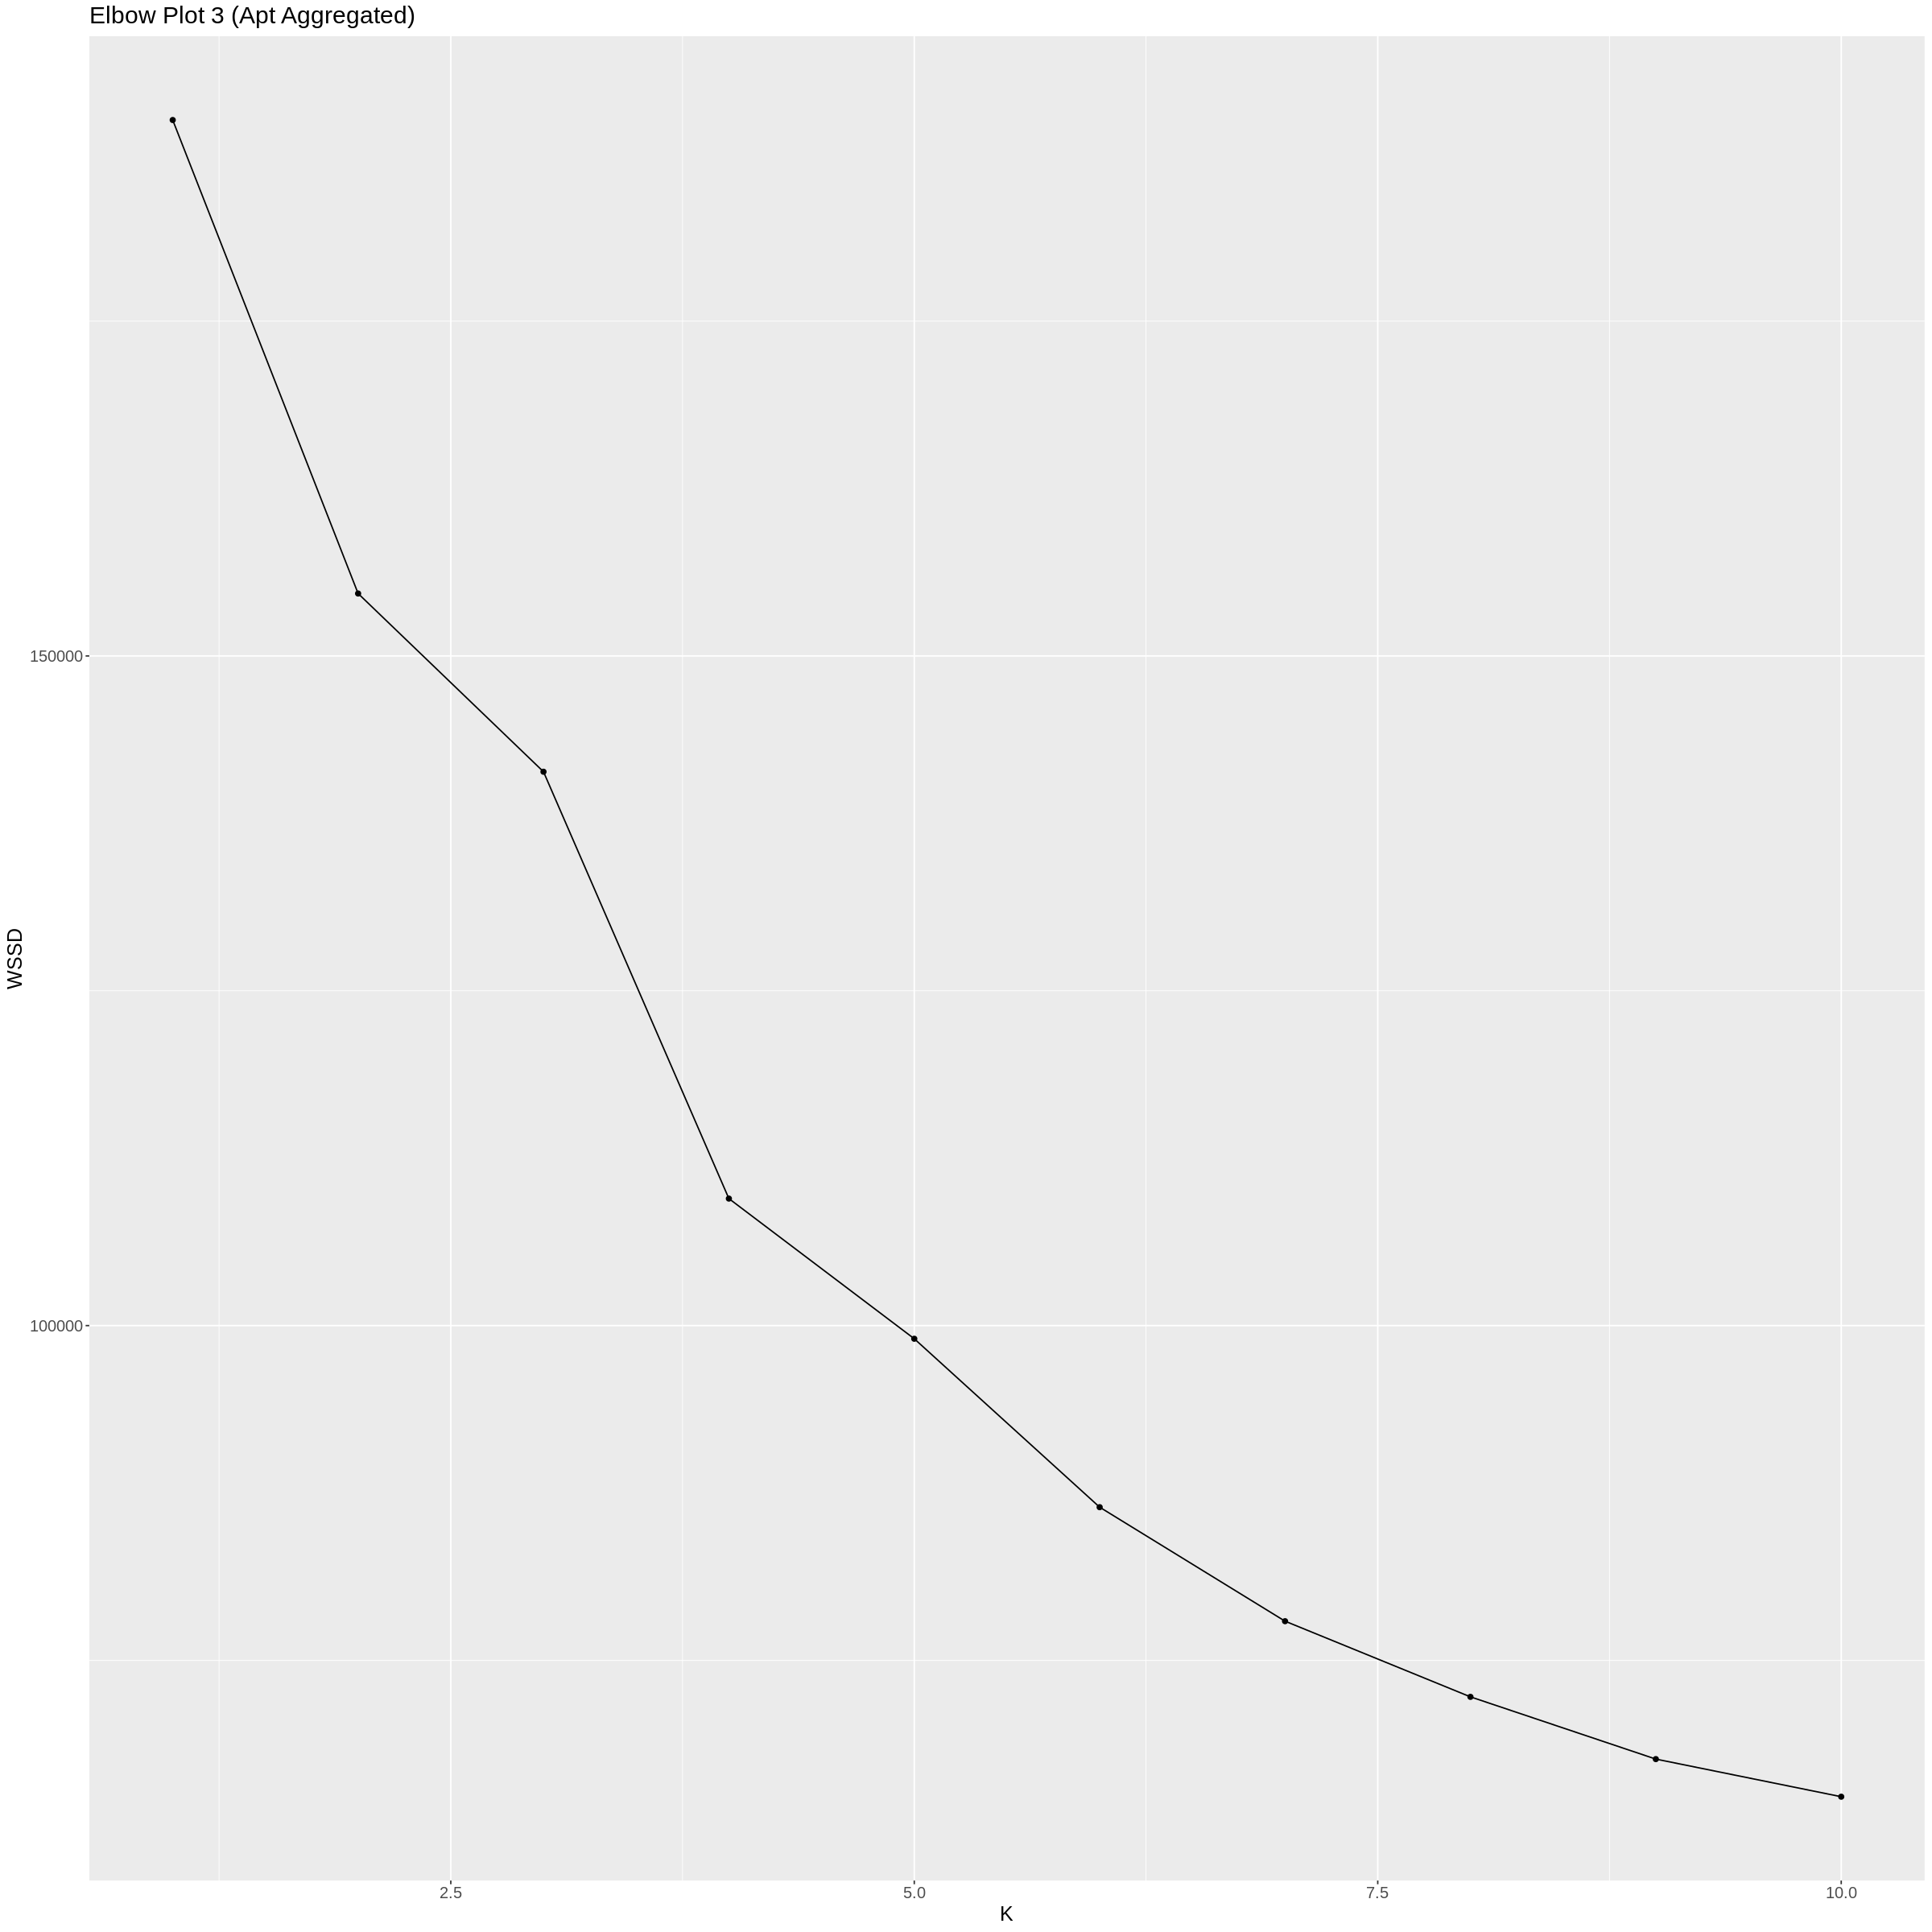

In [116]:
set.seed(9876)
scaled_property_agg_3 <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, AGGREGATE_IMPROVEMENT_VALUE,
           MEAN_YEAR_BUILT, MEAN_BIG_IMPROVEMENT_YEAR, MEAN_TAX_LEVY, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_3, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 3 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

In [120]:
set.seed(9876)
agg_property_clusters <- kmeans(scaled_property_agg_3, centers = 3) |>
    augment(scaled_property_agg_3)
head(agg_property_clusters)

variable_dist <- agg_property_clusters |>
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category)) +
        theme_minimal() +
        theme(text = element_text(size = 20)) +
        xlim(-3, 3) +
        ylim(0, 1.5)
variable_dist

AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE MEAN_YEAR_BUILT
1 -0.28258224                  -0.14447684                  0.86637337    
2 -0.03963238                  -0.08136100                  0.14110545    
3  0.09563793                  -0.01838554                 -0.07962826    
4 -0.28258224                  -0.14447684                  0.86637337    
5  0.54690537                   4.95119050                  1.62317468    
6 -0.09575791                  -0.04584552                  0.48797272    
  MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY lat       long       .cluster
1  0.7110076                -0.16343324   -2.029025 -0.4928004 2       
2 -0.3937640                -0.15754334   -1.996884 -0.6221204 2       
3 -0.7299988                 0.02455912   -1.991206 -0.6278243 1       
4  0.7110076                -0.16343324   -1.985125  1.5019575 2       
5  1.8638128                 1.47281958   -1.978267  1.3259091 2       
6  0.1346051                -0.15537106   -1.964202 -0.6576758 2

Warning message:
“Removed 723 rows containing non-finite values (stat_density).”


Based on the above density plots, year built and big improvement year are highly correlated, so of the two we will only use year built.

Likewise, current land value and current improvement value are highly correlated, so of the two we will only use current land value. Although similarly shaped, mean tax levy has the cluster's densities distributied differenly, so it will also be included.

Latitude and longitude will both still be included, since the plots show that they drive the clusters to differen degrees.

Variables to keep: year built, current land value, tax levy, latitude, longitude

DESCRIPTION MAY CHANGE

In [121]:
set.seed(9876)
#let's try WITHOUT coordinates
#but with the above knowledge that certain variables correlate strongly with each other in clustering
scaled_property_agg_no_coord <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE,
           MEAN_YEAR_BUILT, MEAN_TAX_LEVY) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_no_coord, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 3 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot

AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE MEAN_YEAR_BUILT
1 -0.28258224                  -0.14447684                  0.86637337    
2 -0.03963238                  -0.08136100                  0.14110545    
3  0.09563793                  -0.01838554                 -0.07962826    
4 -0.28258224                  -0.14447684                  0.86637337    
5  0.54690537                   4.95119050                  1.62317468    
6 -0.09575791                  -0.04584552                  0.48797272    
  MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY lat       long       .cluster
1  0.7110076                -0.16343324   -2.029025 -0.4928004 2       
2 -0.3937640                -0.15754334   -1.996884 -0.6221204 2       
3 -0.7299988                 0.02455912   -1.991206 -0.6278243 1       
4  0.7110076                -0.16343324   -1.985125  1.5019575 2       
5  1.8638128                 1.47281958   -1.978267  1.3259091 2       
6  0.1346051                -0.15537106   -1.964202 -0.6576758 2

Warning message:
“Removed 402 rows containing non-finite values (stat_density).”


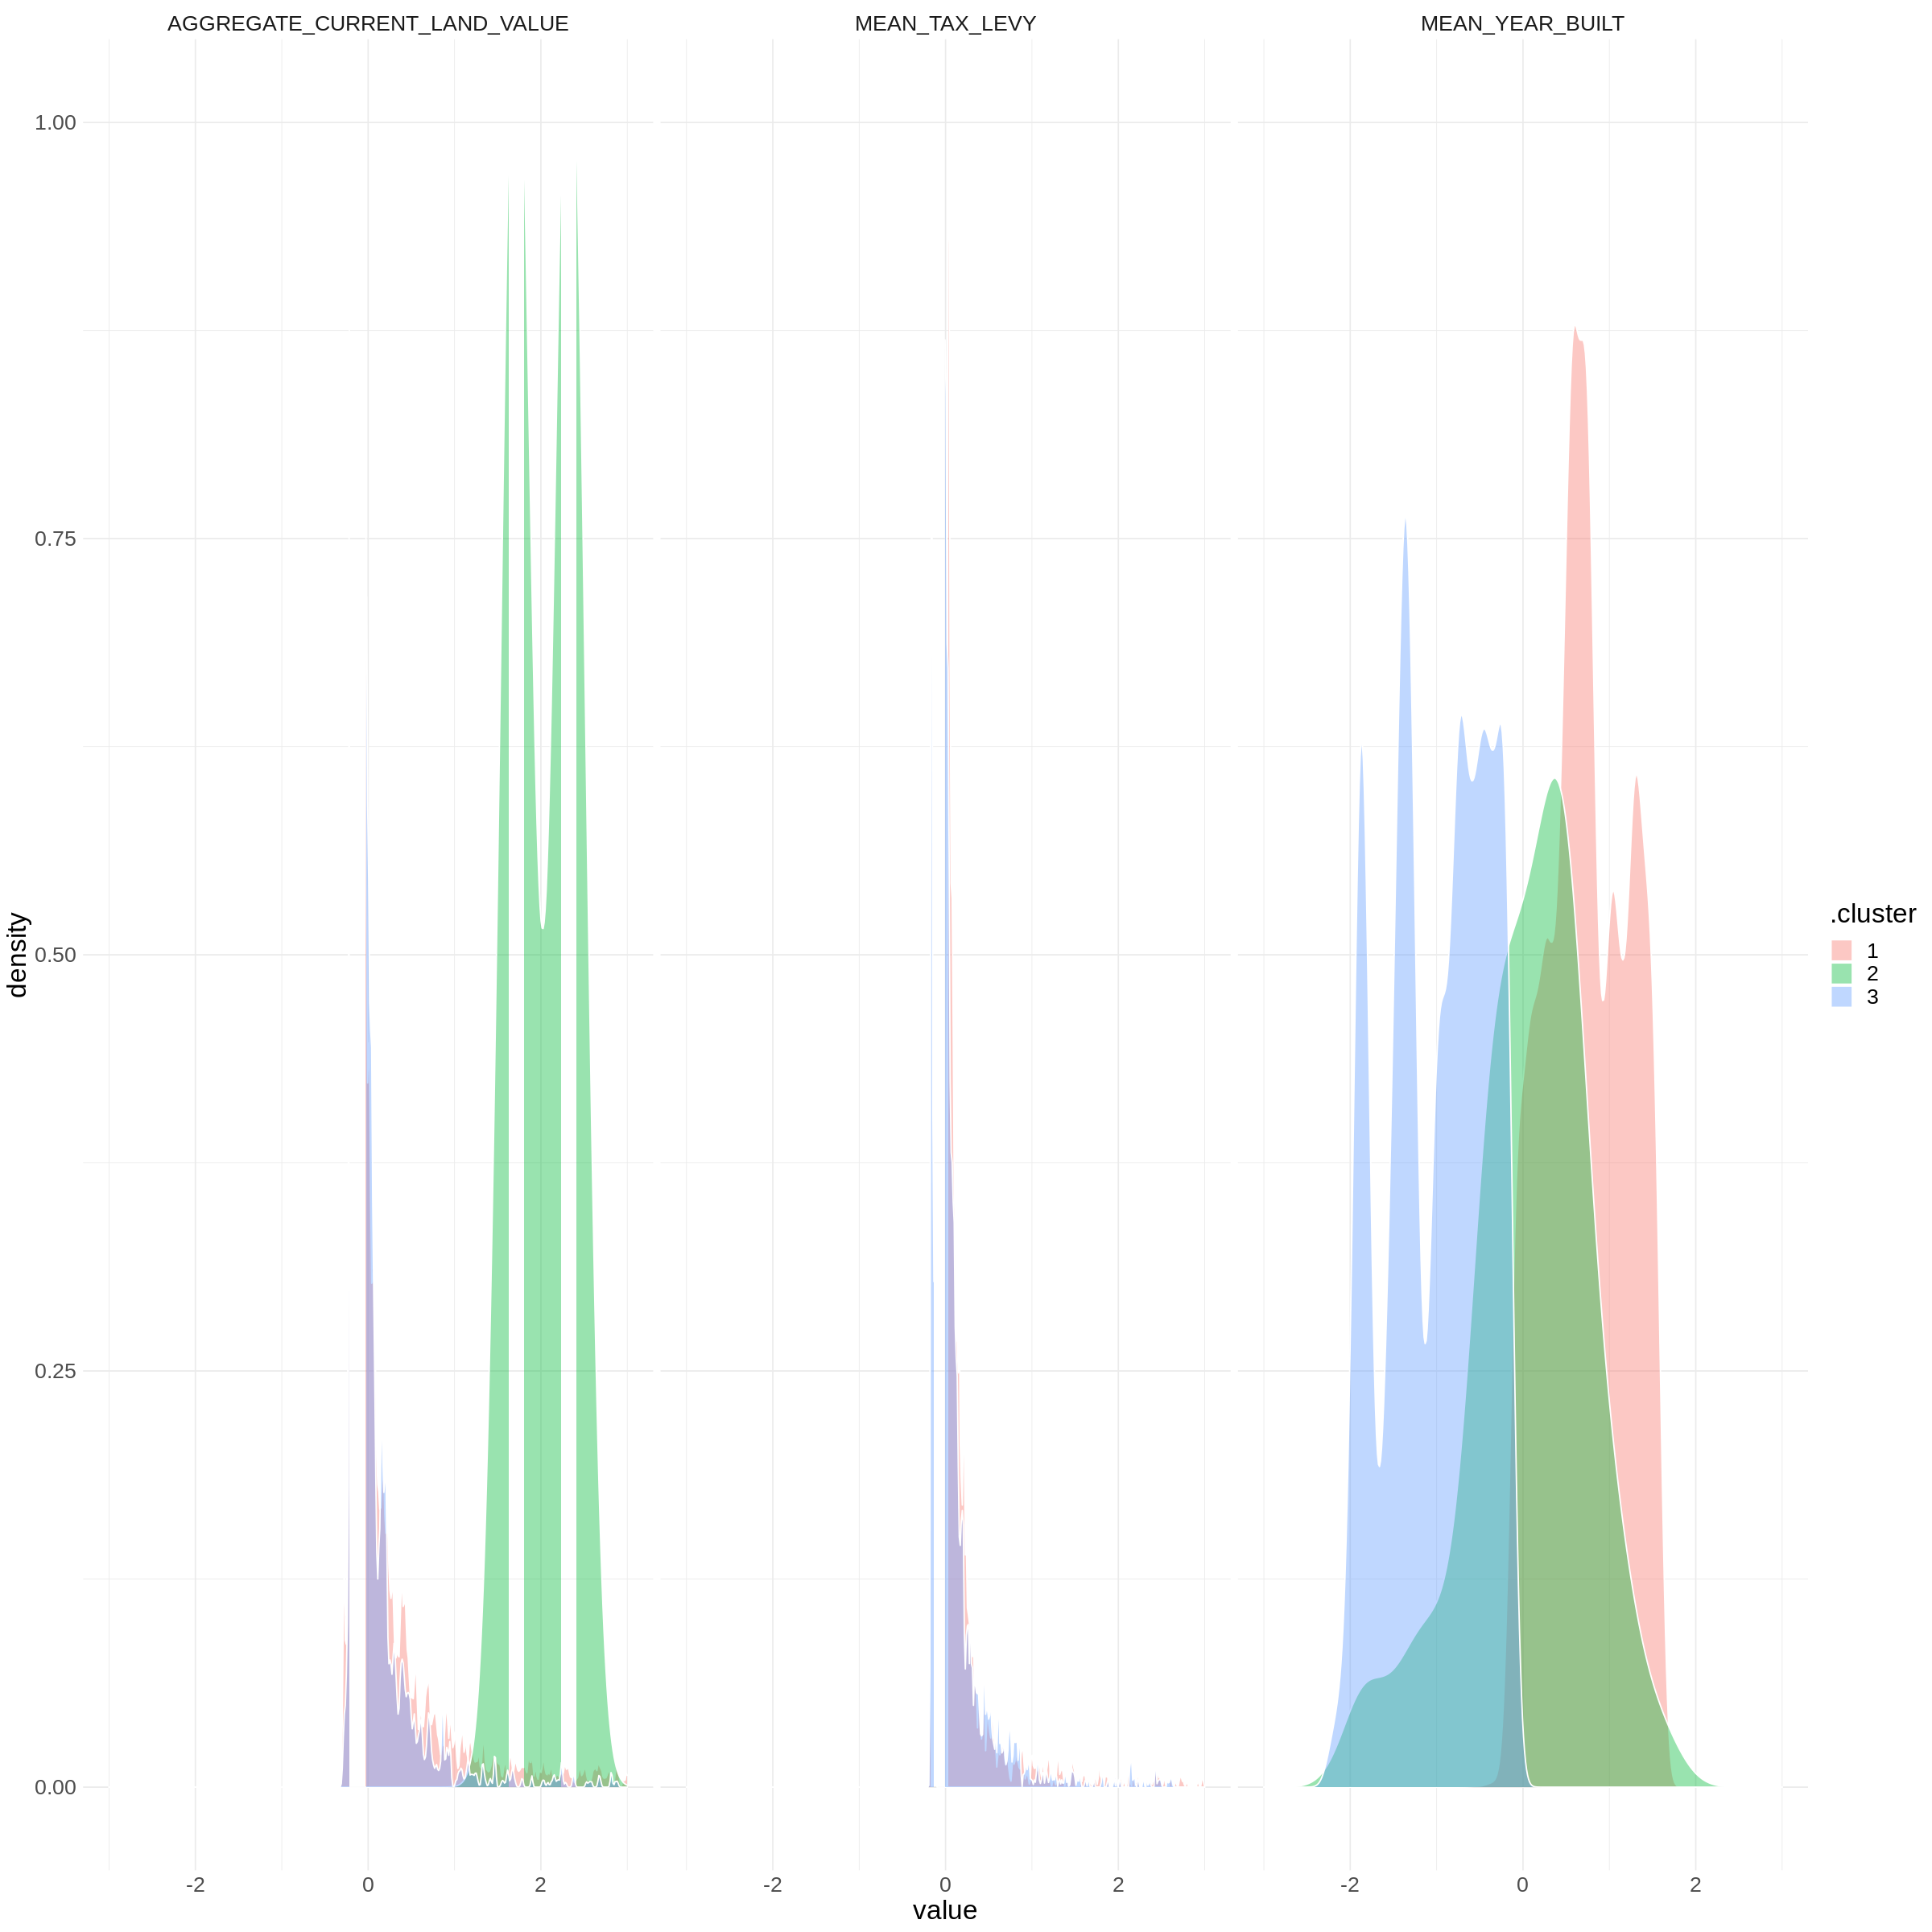

In [123]:
agg_property_clusters_no_coord <- kmeans(scaled_property_agg_no_coord, centers = 3) |>
    augment(scaled_property_agg_no_coord)
head(agg_property_clusters)

variable_dist <- agg_property_clusters_no_coord |>
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category)) +
        theme_minimal() +
        theme(text = element_text(size = 20)) +
        xlim(-3, 3) +
        ylim(0, 1)
variable_dist

Let's try something new. Let's reduce the number of variables based on how much the y correlate.

lat      long      AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE
1 49.20338 -123.1291     2700                         8300                   
2 49.20404 -123.1358  3760000                       592800                   
3 49.20416 -123.1361  5852000                      1176000                   
4 49.20429 -123.0247     2700                         8300                   
5 49.20443 -123.0339 12831000                     47198000                   
6 49.20472 -123.1377  2892000                       921700                   
  MEAN_YEAR_BUILT MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY SAME_ADDRESS_ENTRIES
1 1998            1998                         489.620     1                  
2 1975            1975                        1100.348    11                  
3 1968            1968                       19982.700     1                  
4 1998            1998                         489.620     1                  
5 2022            2022                      170154.000     1                  
6 1986            1986                        1325.594     8

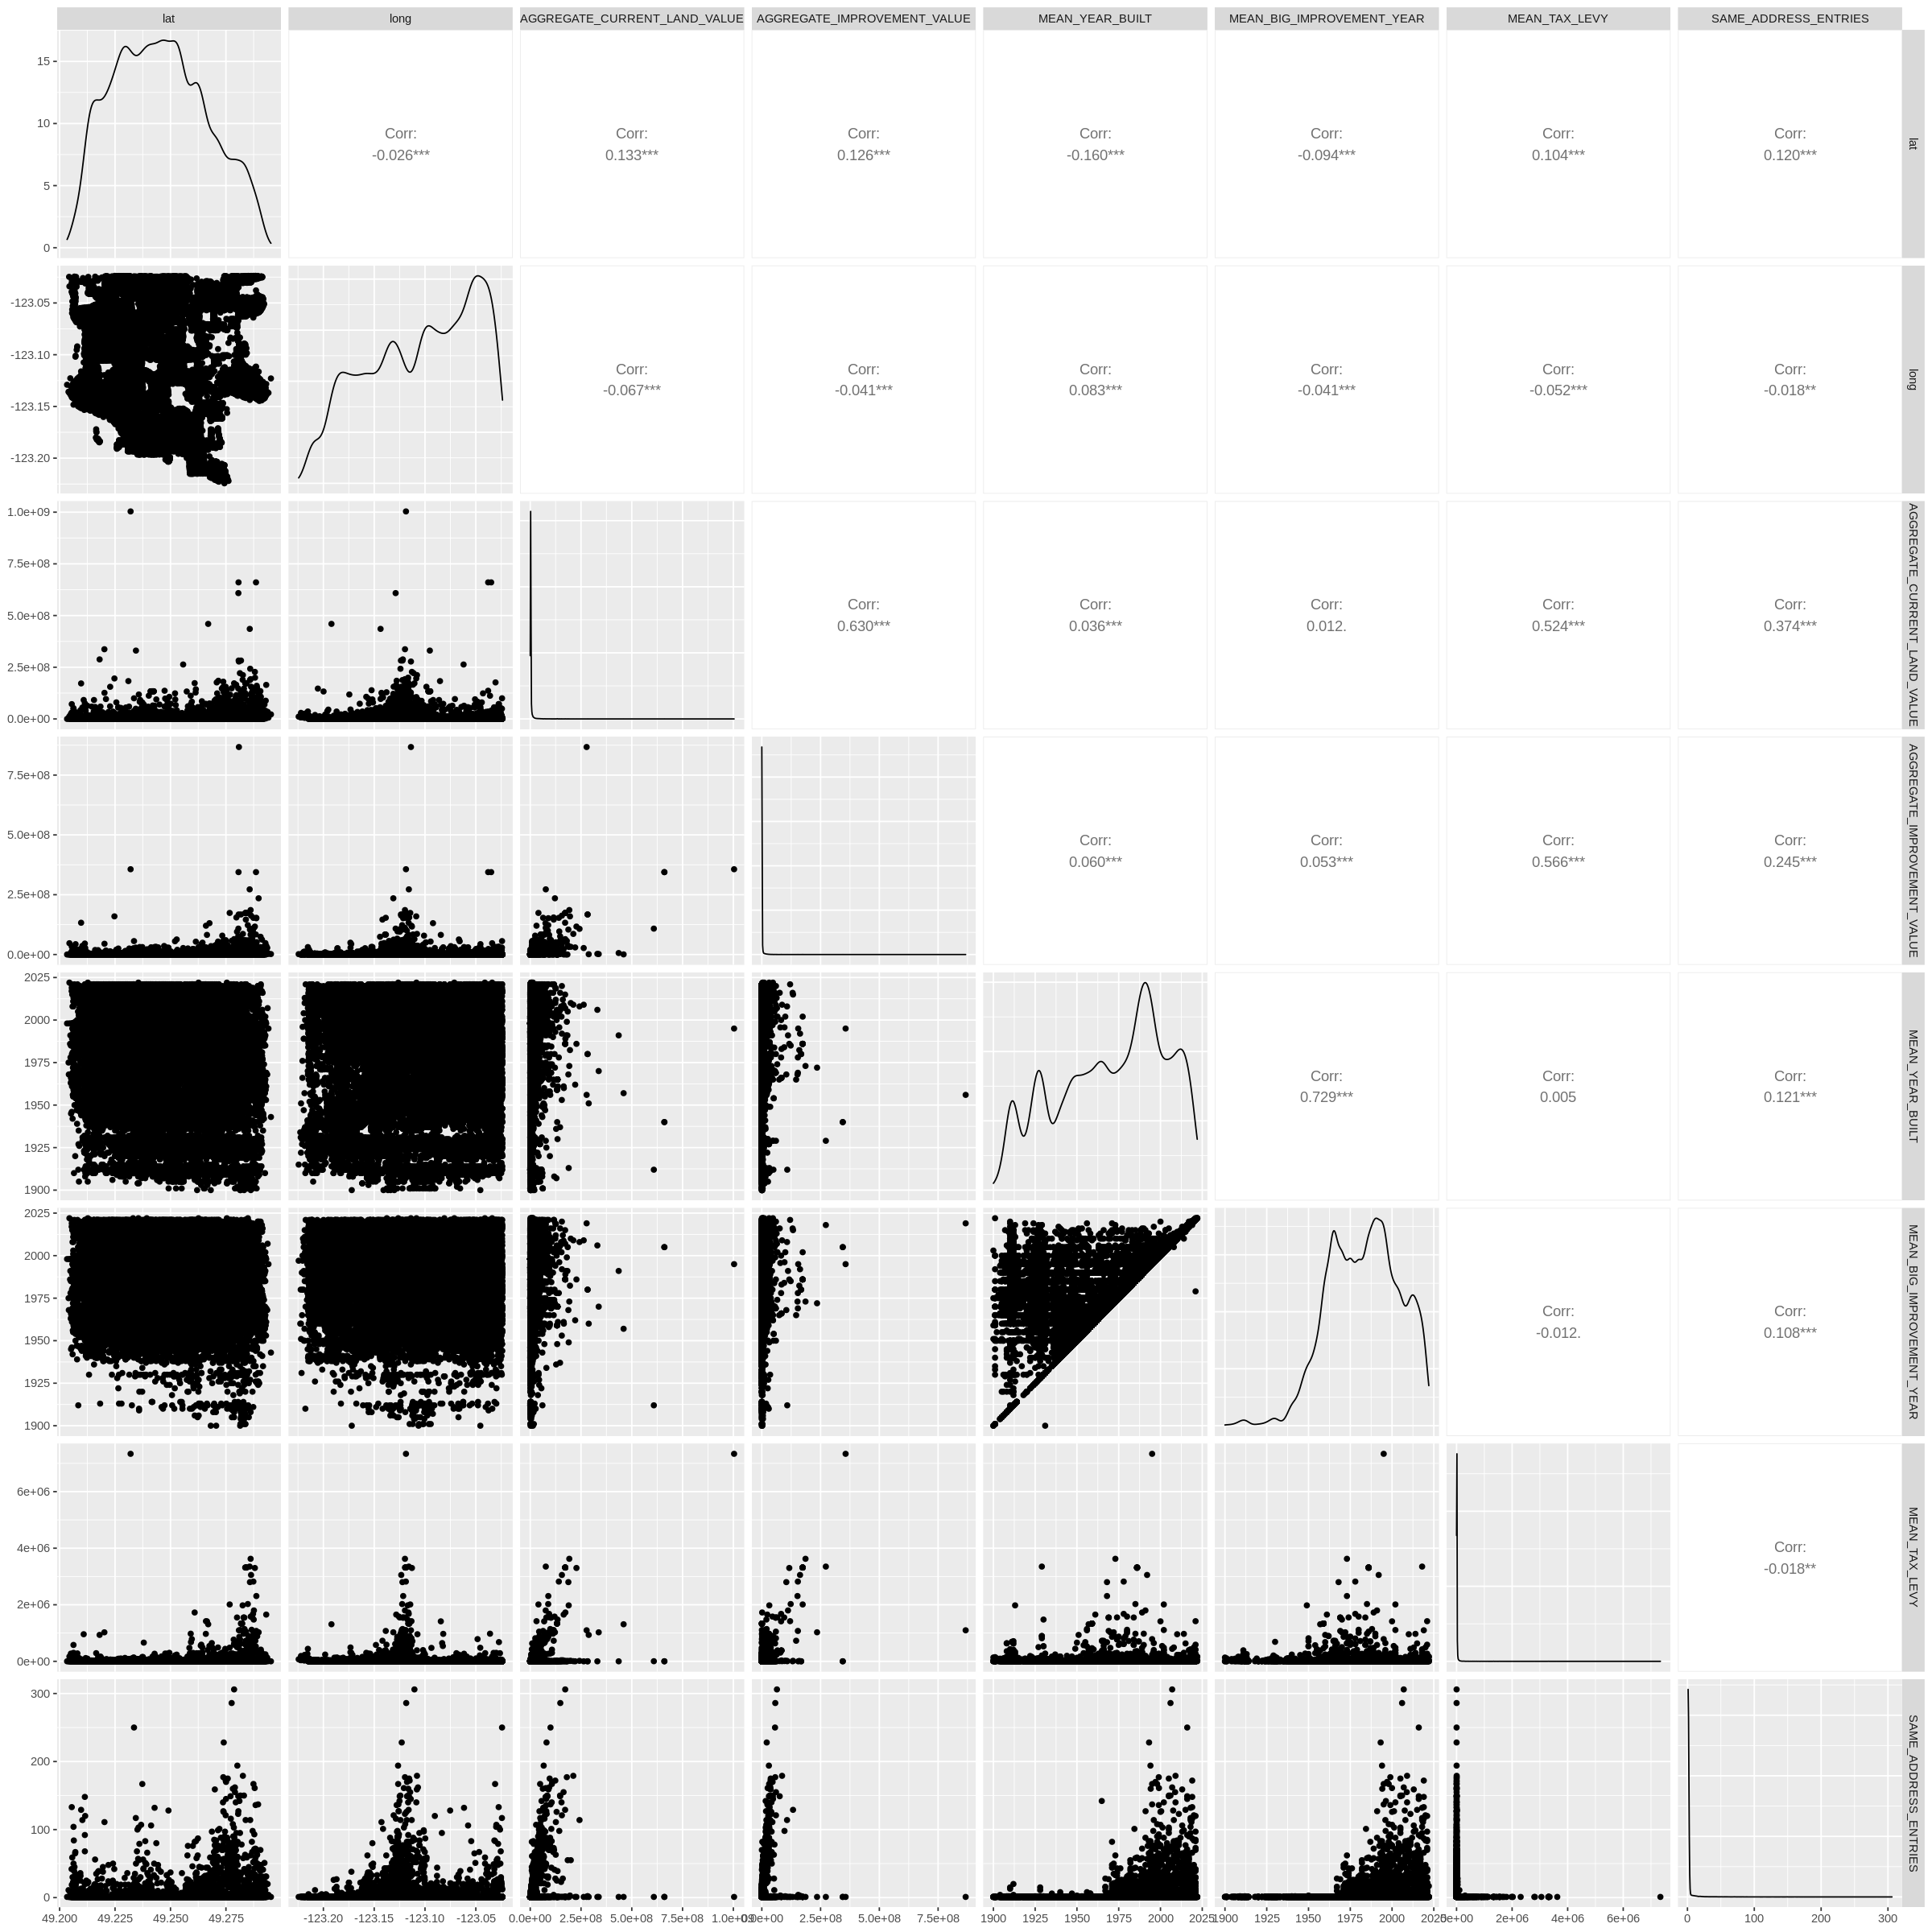

In [6]:
head(housing_aggregated)
ggpairs(housing_aggregated)

Based on the ggpairs plot:

Year built and big improvement year have a strong correlation, so we will proceed with only year built.

Current land value, current improvement value, and tax levy have moderately strong correlations, so we will proceed with only current land value.

Variables kept: current land value, year built, latitude, longitude

In [28]:
set.seed(9876)
scaled_property_gg <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, MEAN_YEAR_BUILT) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_gg, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 5 with coords
#k = 3 or 4 without coords

AGGREGATE_CURRENT_LAND_VALUE MEAN_YEAR_BUILT .cluster
1 -0.28258224                   0.86637337     1       
2 -0.03963238                   0.14110545     3       
3  0.09563793                  -0.07962826     3       
4 -0.28258224                   0.86637337     1       
5  0.54690537                   1.62317468     1       
6 -0.09575791                   0.48797272     1

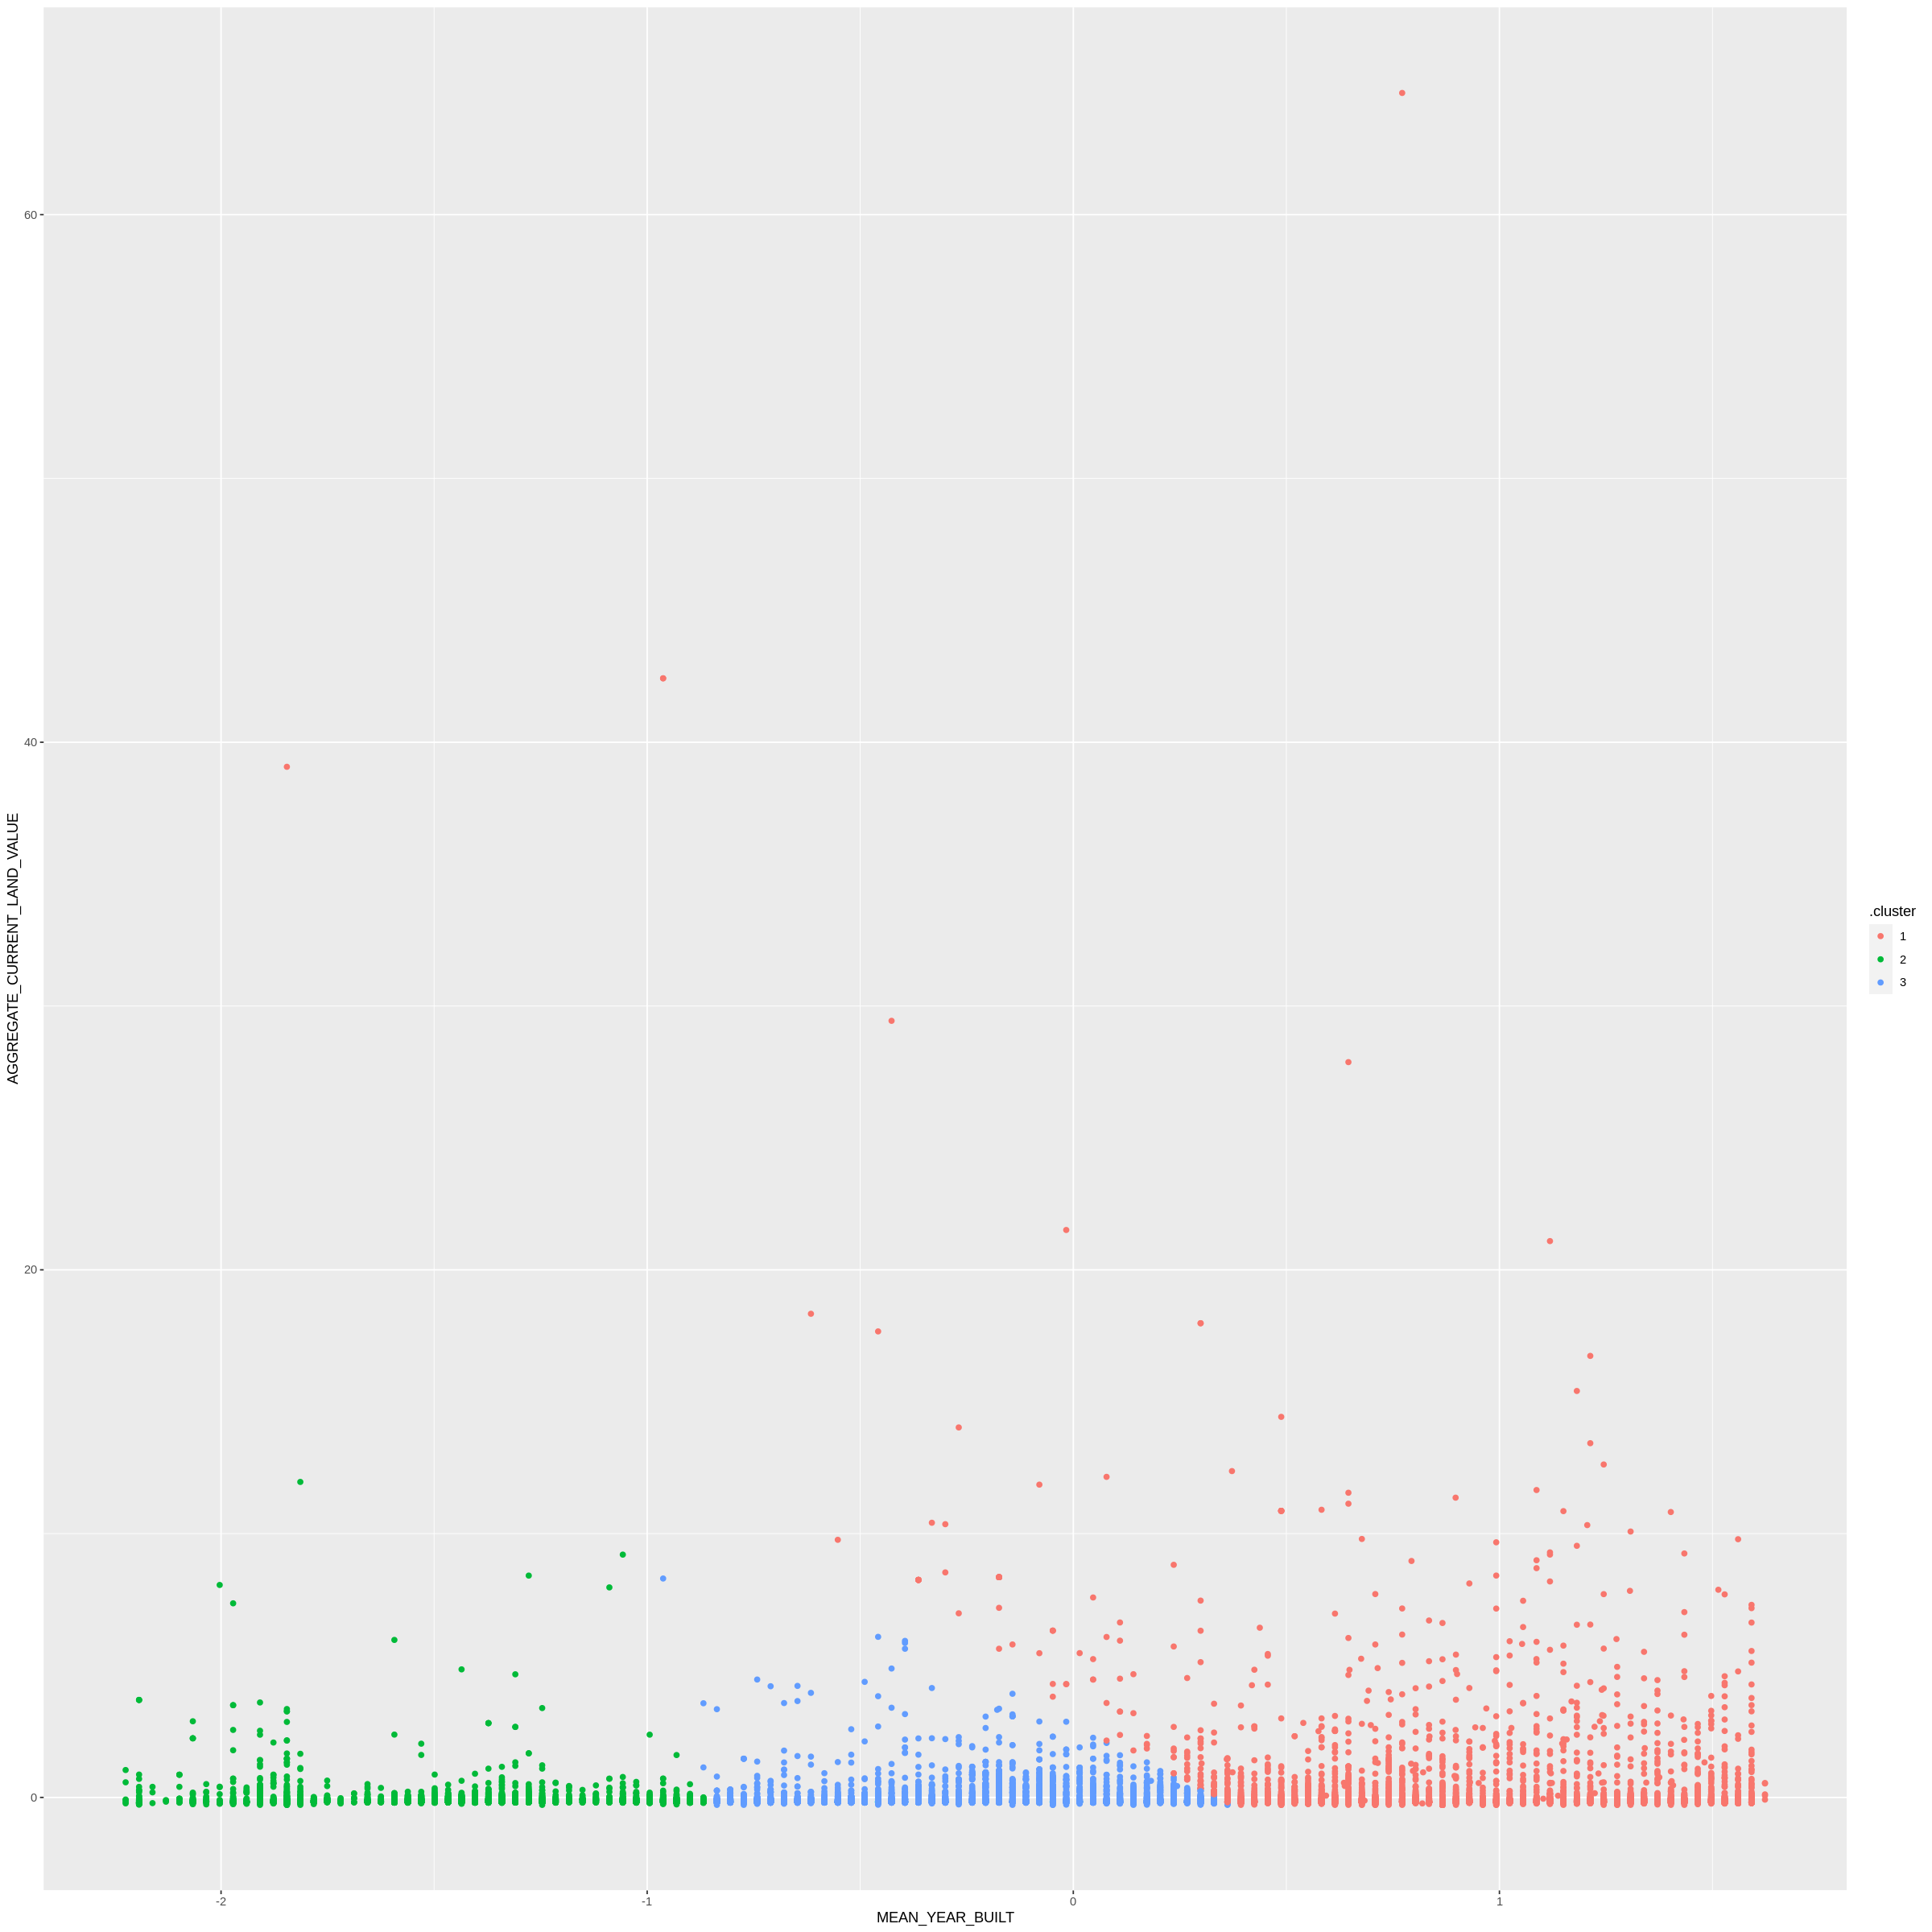

In [29]:
gg_property_clusters <- kmeans(scaled_property_gg, centers = 3) |>
    augment(scaled_property_gg)
head(gg_property_clusters)

gg_property_plot <- gg_property_clusters |>
    ggplot(aes(x = MEAN_YEAR_BUILT, y = AGGREGATE_CURRENT_LAND_VALUE, color = .cluster)) +
    geom_point()
gg_property_plot

In [34]:
set.seed(9876)
#what if we try predicting current land value based on coordinates and year built?
scaled_property_gg <- housing_aggregated |>
    select(MEAN_YEAR_BUILT, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_gg, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot (Apt Aggregated)") +
    theme(text = element_text(size = 15))
# elbow_plot
#k = 4

gg_property_clusters <- kmeans(scaled_property_gg, centers = 4) |>
    augment(scaled_property_gg)
head(gg_property_clusters)

gg_property_bind_cols <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE) |>
    bind_cols(gg_property_clusters)
head(gg_property_bind_cols)

gg_property_plot <- gg_property_bind_cols |>
    ggplot(aes(x = long, y = lat, color = AGGREGATE_CURRENT_LAND_VALUE, shape = .cluster)) +
    geom_point()
gg_property_plot

Warning message:
“did not converge in 10 iterations”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


MEAN_YEAR_BUILT lat       long       .cluster
1  0.86637337     -2.029025 -0.4928004 4       
2  0.14110545     -1.996884 -0.6221204 4       
3 -0.07962826     -1.991206 -0.6278243 4       
4  0.86637337     -1.985125  1.5019575 4       
5  1.62317468     -1.978267  1.3259091 4       
6  0.48797272     -1.964202 -0.6576758 4

AGGREGATE_CURRENT_LAND_VALUE MEAN_YEAR_BUILT lat       long       .cluster
1     2700                      0.86637337     -2.029025 -0.4928004 4       
2  3760000                      0.14110545     -1.996884 -0.6221204 4       
3  5852000                     -0.07962826     -1.991206 -0.6278243 4       
4     2700                      0.86637337     -1.985125  1.5019575 4       
5 12831000                      1.62317468     -1.978267  1.3259091 4       
6  2892000                      0.48797272     -1.964202 -0.6576758 4

<h1> 4. Clustering Model </h1>

In [ ]:
# DON'T CHANGE THE SEED VALUE!
set.seed(9876)

<h1> 5. Results Discussion </h1>

<h1> 6. Conclusion </h1>

<h1> 7. References and Resources </h1>